# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility.  
  For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  
  This volatility targeting improves risk-adjusted returns.

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.

---

By systematically modeling and forecasting RV — using approaches such as HAR models, GARCH-type processes, or machine learning — we can generate signals that are not only academically robust but also directly actionable in trading strategies.


The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [2.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [2.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
   - [2.3. High-Frequency Estimators: Realized Variance](#e)
3. [Stylized facts of realized volatility](#real-vol)
4. [Problem Formualation]()
   - [5.1 Target Variable: 21-Day Realized Variance](#trade-execution-setup)
   - [5.1 Predictors of realized volatility](#trade-execution-setup)
5. [Feature Engineering: Rolling and regime-switching features](#real-vol)
6. [Data-Preprocessing: Data transformation, scaling and redundent features removal](#real-vol)
6. [Methodology: Model Specification, cross-validaiton, evaluation metrics](#real-vol)
7. [Feature Importance and Stability Analysis](#real-vol)
7. [Model Selection: Hyperparameetr Tuning using Purged KFold](#real-vol)
9. [Evaluation: Walk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [2197]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from dotenv import load_dotenv
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.inspection import permutation_importance
from scipy.stats import skew, kurtosis

import utility.plot_helpers as ph
from src.iv_surface.ssvi_model import SSVI
from utility.greeks import solve_strike_for_delta

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

pd.options.mode.chained_assignment = None 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance from `2018` to `2025` and prepare it for analysis.

In [2]:
start = "2010-01-01"
end = "2020-12-31"

spx = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
spx.columns = spx.columns.droplevel("Ticker")
spx.columns.name = None
spx

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000
...,...,...,...,...,...
2020-12-23,3690.010010,3711.239990,3689.280029,3693.419922,3779160000
2020-12-24,3703.060059,3703.820068,3689.320068,3694.030029,1883780000
2020-12-28,3735.360107,3740.510010,3723.030029,3723.030029,3535460000


In [3]:
spx.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [4]:
spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

,Close,High,Low,Open,Volume,returns
Date,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.003111
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.000545
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.003993
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.002878
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.001745
...,...,...,...,...,...,...
2020-12-23,3690.010010,3711.239990,3689.280029,3693.419922,3779160000,0.000746
2020-12-24,3703.060059,3703.820068,3689.320068,3694.030029,1883780000,0.003530
2020-12-28,3735.360107,3740.510010,3723.030029,3723.030029,3535460000,0.008685


Text(0.5, 1.0, 'Log Returns')

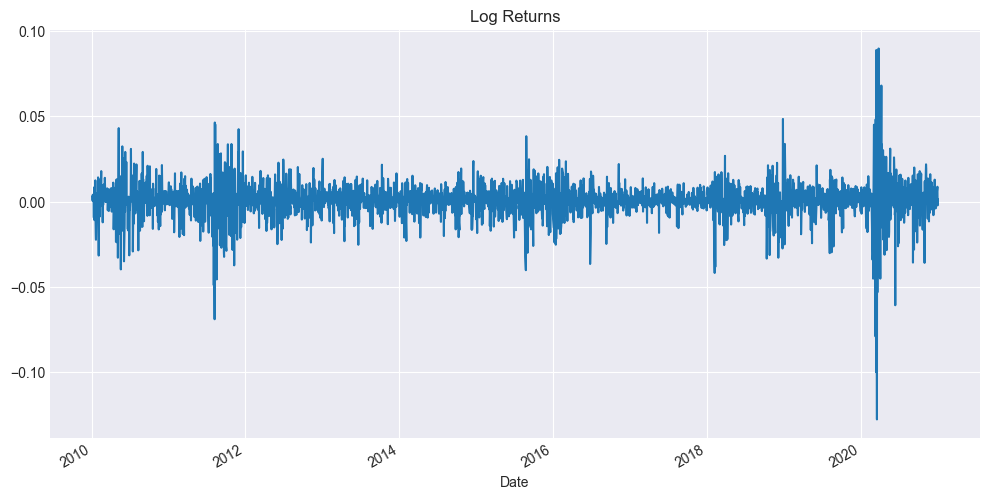

In [5]:
spx["returns"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

## 2.1 Historical / Close-to-Close

The simplest approach uses only closing price data and is often called the **close-to-close estimator**.   It computes realized volatility from consecutive daily returns. This estimator serves as a useful **benchmark**, but it suffers from several drawbacks: it ignores intraday variation, overnight jumps, and the information contained in opening, high, and low prices, which often makes it downward biased.

Formally, over a horizon $H$:

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

In [6]:
def rv_close_to_close(returns, h=21, ann=252):
    var = returns.pow(2).rolling(h).sum() * (ann / h)
    return np.sqrt(var)

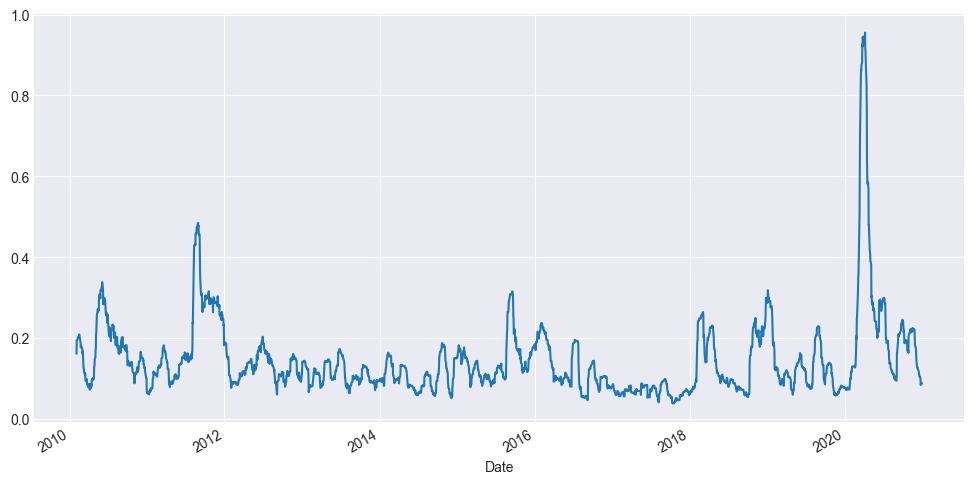

In [7]:
spx["rv_close"] = rv_close_to_close(spx["returns"], h=21)
spx["rv_close"].plot(figsize=(12, 6))
plt.show()

## 2.2 Range-Based Proxies (OHLC)

Instead of relying only on closing prices, we can extract more information from each trading day by incorporating the **Open, High, Low, and Close (OHLC)** prices.  
Over the years, several range-based estimators have been proposed, each addressing specific shortcomings of the close-to-close method and earlier estimators.  
These approaches typically reduce variance in the volatility estimate and account for intraday dynamics, but each comes with its own assumptions and limitations.

### 2.2.1 Parkinson Estimator

The **Parkinson (1980) estimator** uses the daily high–low range to capture intraday price variability.  
By relying on the full range rather than just closing prices, it provides a more efficient estimate of volatility under the assumption of a **driftless geometric Brownian motion**.  

However, it ignores opening and closing prices and is highly sensitive to jumps or bid–ask bounce at the extremes of the trading day.

Formally, over a horizon $H$:

$$
RV^{\text{Parkinson}}_{t,H} 
= \sqrt{ \frac{252}{4H \ln(2)} \sum_{j=1}^H \left[ \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right]^2 }
$$

In [8]:
def rv_parkinson(high, low, h=21, ann=252):
    rp = np.log(high / low).pow(2)  # per-day range variance proxy
    var = rp.rolling(h, min_periods=h).sum() * (ann / (4 * np.log(2) * h))
    return np.sqrt(var)

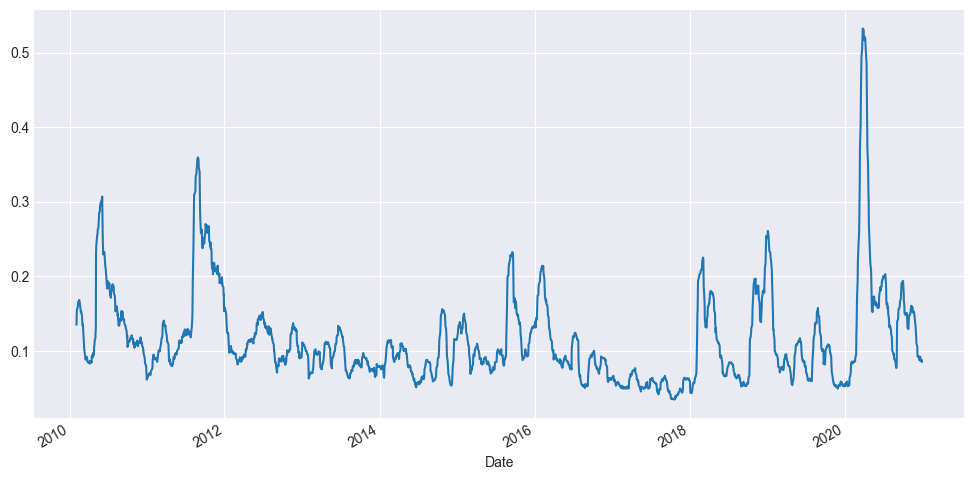

In [9]:
spx["rv_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)
spx["rv_parkinson"].plot(figsize=(12, 6))
plt.show()

### 2.2.2 Garman–Klass Estimator

The **Garman–Klass (1980) estimator** improves upon the Parkinson measure by incorporating not only the daily high and low, but also the open and close prices.  
This allows it to capture more information about intraday price variation and reduce estimation variance under the assumption of a driftless geometric Brownian motion.  

However, like the Parkinson estimator, it can be biased in the presence of significant drift or opening jumps, since it assumes zero drift and continuous trading.

Formally, over a horizon $H$:

$$
RV^{\text{GK}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ \tfrac{1}{2} \left( \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right)^2 
- (2\ln(2) - 1) \left( \ln\!\left(\tfrac{C_{t+j}}{O_{t+j}}\right) \right)^2 
\right] }
$$

In [10]:
def rv_garman_klass(open_, high, low, close, h=21, ann=252):
    # Daily GK variance (no drift)
    rs = 0.5 * (np.log(high/low).pow(2)) - (2*np.log(2) - 1) * (np.log(close/open_).pow(2))
    var = rs.rolling(h).sum() * (ann / h)
    return np.sqrt(var)

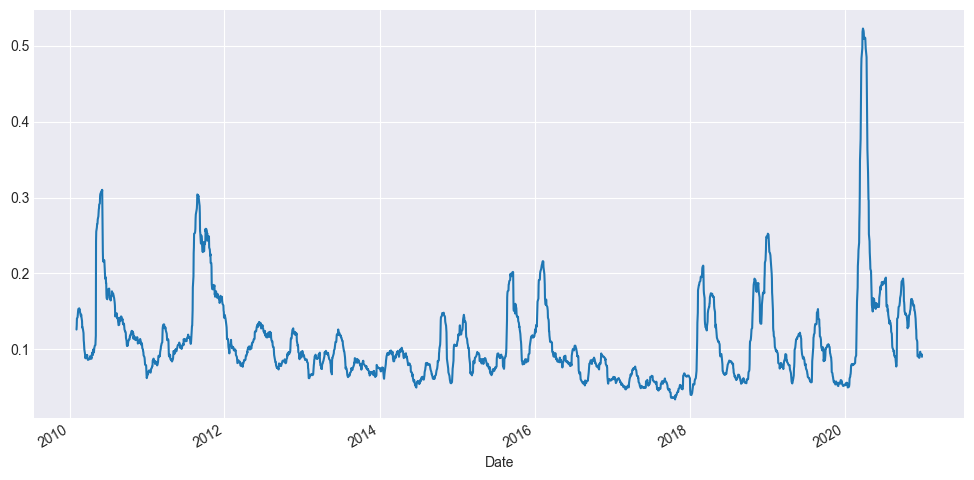

In [11]:
spx["rv_gk"] = rv_garman_klass(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_gk"].plot(figsize=(12, 6))
plt.show()

### 2.2.3 Rogers–Satchell Estimator

The **Rogers–Satchell (1991) estimator** was introduced to overcome one of the limitations of the Parkinson and Garman–Klass estimators: their assumption of zero drift.  
The Rogers–Satchell measure is **drift-robust**, making it better suited for assets that experience trending behavior.  
It uses all four OHLC prices, but in a different functional form that explicitly accommodates nonzero expected returns.  

While it handles drift effectively, it remains sensitive to microstructure noise and extreme jumps at the open or close.

Formally, over a horizon $H$:

$$
RV^{\text{RS}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ 
\ln\!\left(\tfrac{H_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{H_{t+j}}{O_{t+j}}\right) 
+ \ln\!\left(\tfrac{L_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{L_{t+j}}{O_{t+j}}\right) 
\right] }
$$

In [12]:
def rv_rogers_satchell(open_, high, low, close, h=21, ann=252):
    term1 = np.log(high/close) * np.log(high/open_)
    term2 = np.log(low/close) * np.log(low/open_)
    rs = (term1 + term2)
    var = rs.rolling(h).sum() * (ann/h)
    return np.sqrt(var)

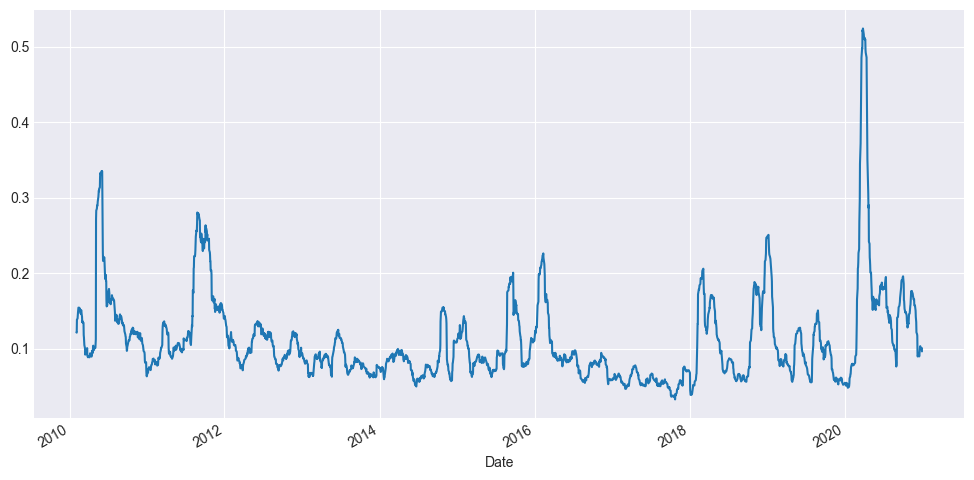

In [13]:
spx["rv_rs"] = rv_rogers_satchell(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_rs"].plot(figsize=(12, 6))
plt.show()

### 2.2.4 Yang–Zhang Estimator

The **Yang–Zhang (2000) estimator** combines the advantages of previous methods by incorporating overnight variance, open-to-close variance, and the Rogers–Satchell range-based component.  
It is **unbiased in the presence of drift**, less sensitive to opening jumps, and has significantly lower estimation variance compared to Parkinson, Garman–Klass, or Rogers–Satchell taken alone.  

This makes Yang–Zhang one of the most efficient daily volatility estimators available when OHLC data are present.

Formally, the daily Yang–Zhang variance can be expressed as:

$$
\sigma^2_{YZ} = \sigma^2_O + k \, \sigma^2_C + (1-k)\, \sigma^2_{RS}
$$

where  
- $\sigma^2_O = \big( \ln(O_t / C_{t-1}) \big)^2$ is the overnight variance,  
- $\sigma^2_C = \big( \ln(C_t / O_t) \big)^2$ is the open-to-close variance,  
- $\sigma^2_{RS}$ is the Rogers–Satchell variance component,  
- $k \approx 0.34$ is a weight chosen to minimize bias and variance.  

Aggregating over a horizon $H$:

$$
RV^{\text{YZ}}_{t,H} = \sqrt{ \frac{252}{H} \sum_{j=1}^H \sigma^2_{YZ,\,t+j} }
$$

In [14]:
def rv_yang_zhang(open_, high, low, close, h=21, ann=252, k=0.34):
    # Overnight return variance
    oc = np.log(open_/close.shift(1))
    sigma_o = oc.pow(2)

    # Open-to-close variance
    co = np.log(close/open_)
    sigma_c = co.pow(2)

    # Rogers–Satchell component
    rs = (
        np.log(high/close) * np.log(high/open_) +
        np.log(low/close) * np.log(low/open_)
    )

    # Daily YZ variance
    yz = sigma_o + k*sigma_c + (1-k)*rs

    var = yz.rolling(h, min_periods=h).sum() * (ann/h)
    return np.sqrt(var)

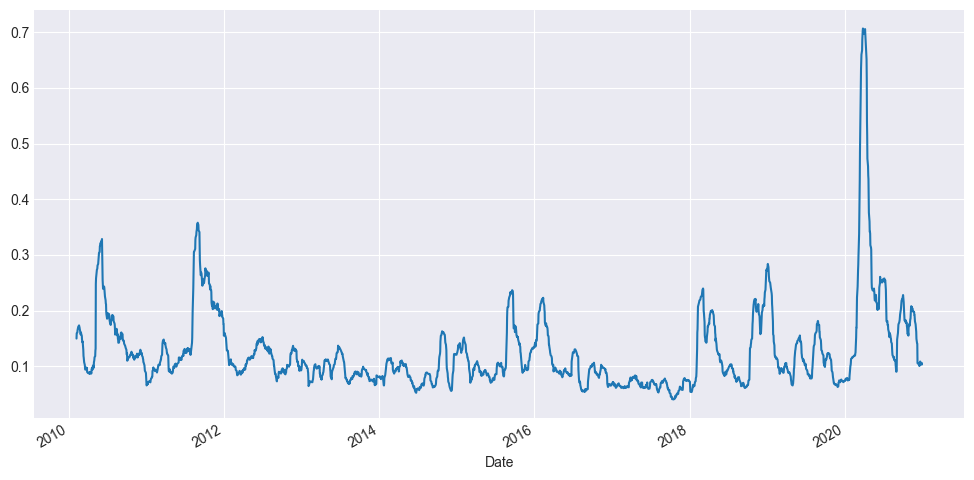

In [15]:
spx["rv_yz"] = rv_yang_zhang(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_yz"].plot(figsize=(12, 6))
plt.show()

## 2.3 Which Estimator to choose ?

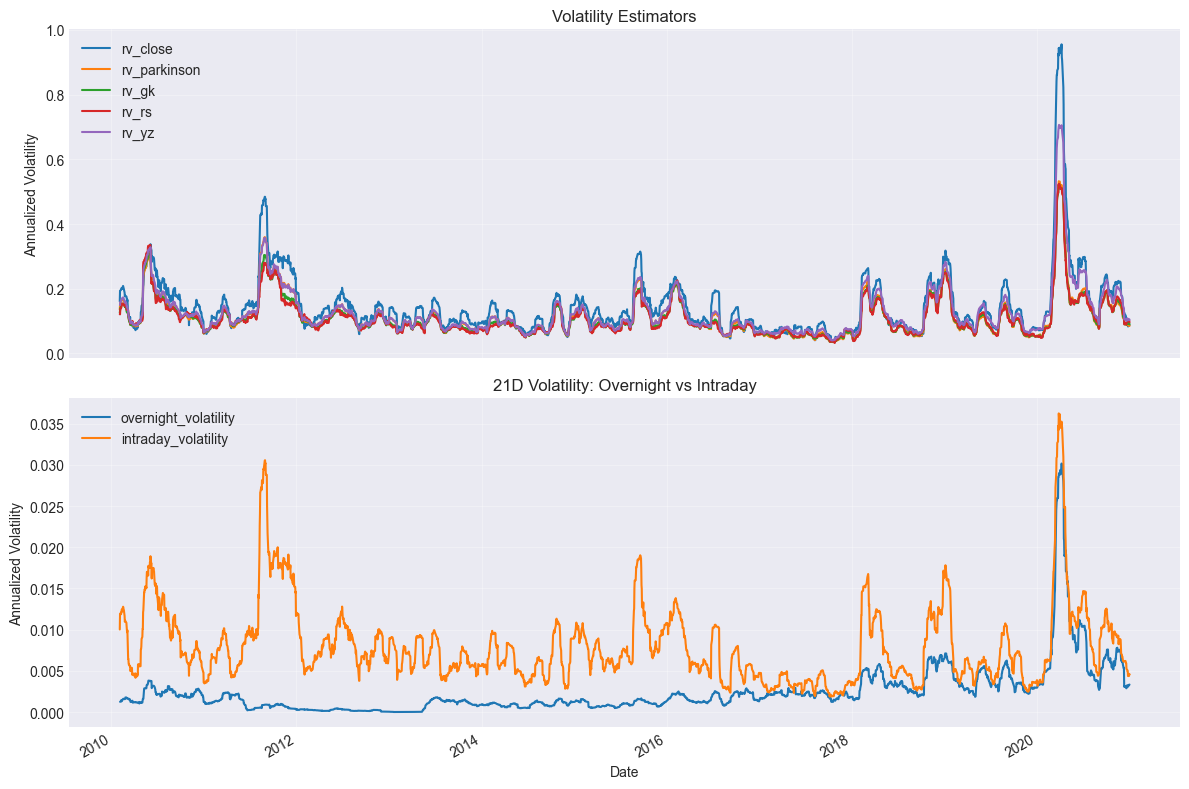

In [16]:
spx["overnight_volatility"] = np.log(spx["Open"] / spx["Close"].shift(1)).rolling(21).std()
spx["intraday_volatility"] = np.log(spx["Close"] / spx["Open"]).rolling(21).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- top panel: volatility estimators ---
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax1)
ax1.set_title("Volatility Estimators")
ax1.set_ylabel("Annualized Volatility")
ax1.grid(alpha=0.3)
ax1.legend()

# --- bottom panel: overnight vs intraday volatility ---
spx[["overnight_volatility", "intraday_volatility"]].plot(ax=ax2)
ax2.set_title("21D Volatility: Overnight vs Intraday")
ax2.set_ylabel("Annualized Volatility")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

- **Insight:** You’ll see that in stress regimes (e.g., 2008, COVID-19 crash), *overnight moves dominate*. YZ explicitly accounts for this.

### 2.3 High-Frequency Estimators: Realized Variance

With **5-minute high-frequency data**, we can incorporate much more intraday information than when relying only on daily OHLC data.  
In this notebook, we use **E-mini S&P 500 futures (ES)**, which trade almost 24 hours a day, so the realized measure naturally includes overnight returns as well.  

The choice of a 5-minute sampling grid is widely recognized as the best trade-off between capturing information and avoiding microstructure distortions: it explains about **90–95% of daily integrated variance**. At higher frequencies (e.g., 1-min, tick), **microstructure noise**—such as bid–ask bounce and discrete price jumps—becomes more prominent, requiring more advanced techniques (e.g., **pre-averaged RV** or **realized kernels**).  

As a baseline, we consider the **realized variance (RV)** estimator, defined over a day $t$ with intraday returns $r_{t,i}$ as:

$$
RV_t = \sum_{i=1}^{N_t} r_{t,i}^2,
\quad 
r_{t,i} = \ln\!\left(\frac{P_{t,i}}{P_{t,i-1}}\right)
$$

where $N_t$ is the number of 5-minute intervals within day $t$, and $P_{t,i}$ denotes the price at interval $i$.

In [17]:
es_5min = pd.read_csv("data/intermediate/es-5m.csv", 
                 sep=";", 
                 header=None,
                 names=["date","time","open","high","low","close","volume"])

es_5min["datetime"] = pd.to_datetime(es_5min["date"] + " " + es_5min["time"], 
                                     format="%d/%m/%Y %H:%M:%S")

es_5min = es_5min.drop(columns=["date","time"]).set_index("datetime").sort_index()

es_5min = es_5min.loc[start:end]
es_5min

,open,high,low,close,volume
datetime,,,,,
2010-01-03 17:00:00,1113.75,1115.25,1113.25,1114.25,4700
2010-01-03 17:05:00,1114.25,1115.50,1114.25,1114.75,1804
2010-01-03 17:10:00,1114.50,1115.25,1114.50,1115.00,785
2010-01-03 17:15:00,1115.25,1116.00,1114.75,1115.75,1143
2010-01-03 17:20:00,1115.75,1116.25,1115.50,1116.00,643
...,...,...,...,...,...
2020-12-31 15:35:00,3746.75,3747.25,3746.00,3746.75,902
2020-12-31 15:40:00,3746.75,3747.25,3746.50,3747.00,582
2020-12-31 15:45:00,3747.00,3747.50,3745.75,3746.75,879


In [18]:
es_5min.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [19]:
es_5min[es_5min.index.duplicated(keep=False)]

,open,high,low,close,volume
datetime,,,,,


In [20]:
es_5min = es_5min[~es_5min.index.duplicated(keep="last")]

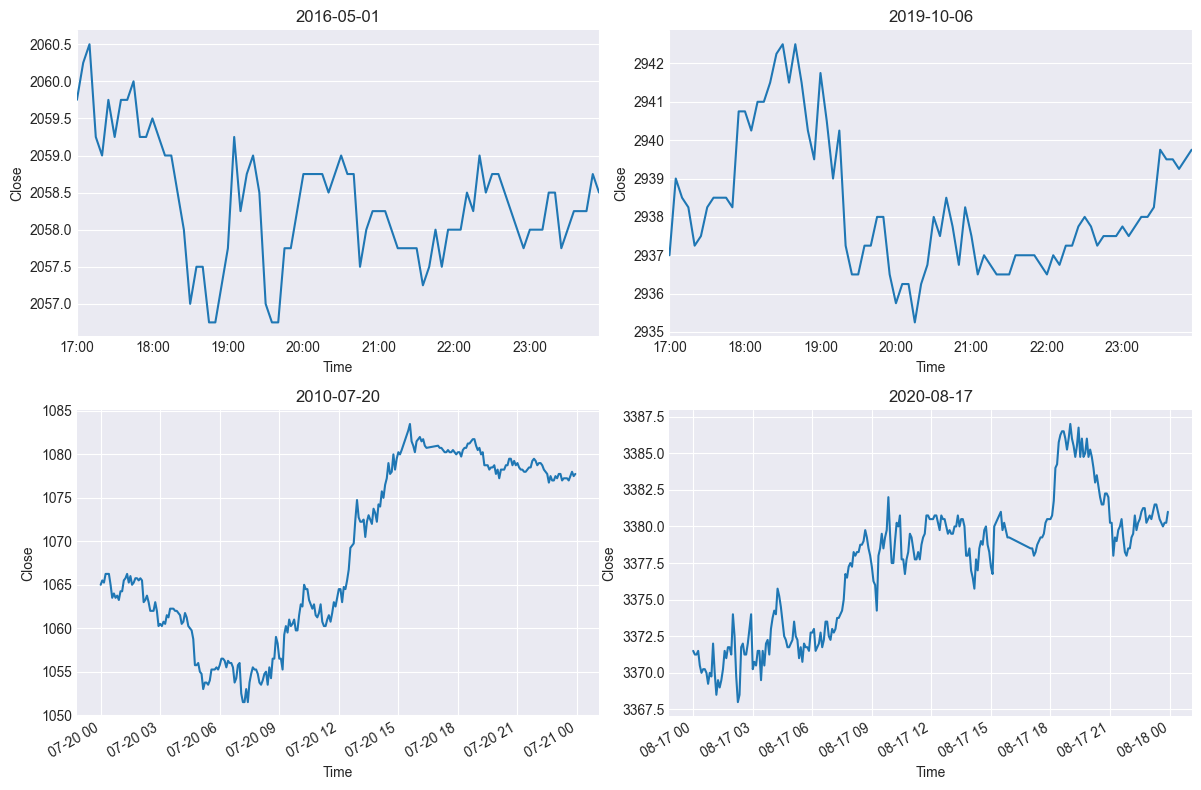

In [21]:
# pick 4 random days
all_days = es_5min.index.normalize().unique().date
days = np.random.choice(all_days, size=4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, day in zip(axes.ravel(), days):
    es_5min.loc[str(day), "close"].plot(ax=ax)
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("Time")
    ax.set_ylabel("Close")

plt.tight_layout()
plt.show()

There are some interpolated prices, but oeverall teh quality looks good comapred to yfinance for isnatcne where msot of the series would be interpolated.

In [ ]:
def daily_realized_variance(close, rth_start: str = "09:30", rth_end: str = "16:00"):
    """
    Compute daily realized variance from intraday data:
        RV_t = sum_i r_{t,i}^2, where r_{t,i} = log(P_{t,i}/P_{t,i-1})
    """
    # intraday log returns
    tod = close.index.strftime("%H:%M")
    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()
    r = np.log(rth).diff()

    # sum of squared intraday returns by day
    rv_daily = r.pow(2).groupby(rth.index.date).sum()
    rv_daily.index = pd.to_datetime(rv_daily.index)
    rv_daily.name = "var_daily"

    return rv_daily

In [23]:
daily_rv = daily_realized_variance(es_5min["close"])
es_rv_21 = np.sqrt(daily_rv.rolling(21).mean() * 252)

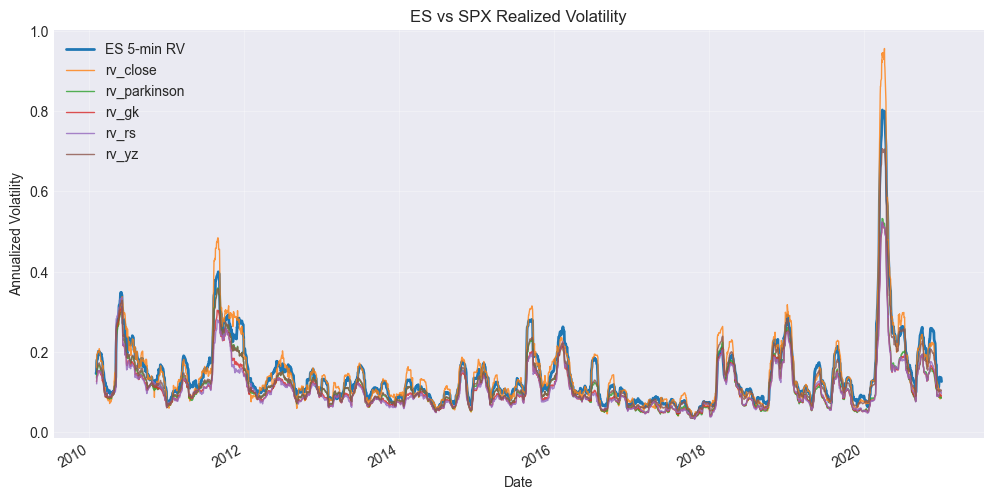

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

es_rv_21.plot(ax=ax, label="ES 5-min RV", lw=2)
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax, lw=1, alpha=0.8)

ax.set_title("ES vs SPX Realized Volatility")
ax.set_ylabel("Annualized Volatility")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

The difference between close-to-close and realized variance is evne more pormiennt at daily frequency.

# **3. Stylized facts of daily volatility**

Here we will be investgating stylized facts of daily volatility that can be used for modelling perspective. The idea is to highlight the key charcetristics of daily varaicne that can be leveraged to forecast the future volaitltiy. From a modellign perspective it is betetr to work diertcly with varaicne instea dof std (isnce variance is additive) as well as dealing with the daily one isnetad of teh monthyl rollign one (which does not align with the stylized fatcs which come from daily frequency).

Volatility us 

- ACF-PACF of saurred returns (persistence)
- Volatiltiy clusterign & Mean reversion
- Leverage effect

## 3.1 Volatility clustering

It is the msot important phenomena as volatility is not constant, it evolves in low and high volatility regimes respecitvely. The idea is that high (resp. low) level of voalitlities tend to be follwoed by high (resp. low) level of volaitlity respectievly.

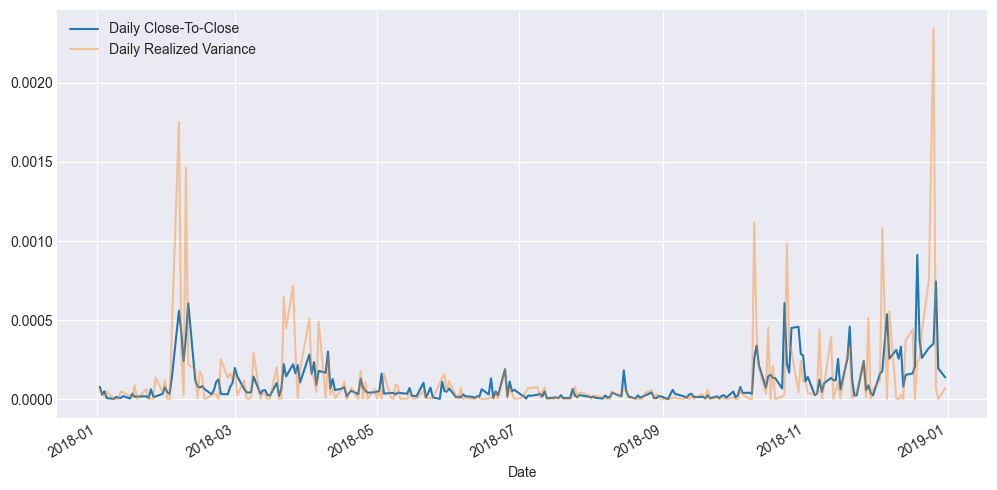

In [25]:
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

## 3.2 Long Memory / Slow Decay

Squarred retursn and realized varaicne show strong persiteenc eover many lags. Means today’s volatility has predictive power even months ahead. Thi smotivates the use of HAR-RV models that parsimuniusly include many lags until monthyl lags.

In [26]:
def plot_acf_pacf(series, lags=40, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF {title}")

    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method="ywm")  # Yule-Walker-M estimator
    axes[1].set_title(f"PACF {title}")

    plt.tight_layout()
    plt.show()

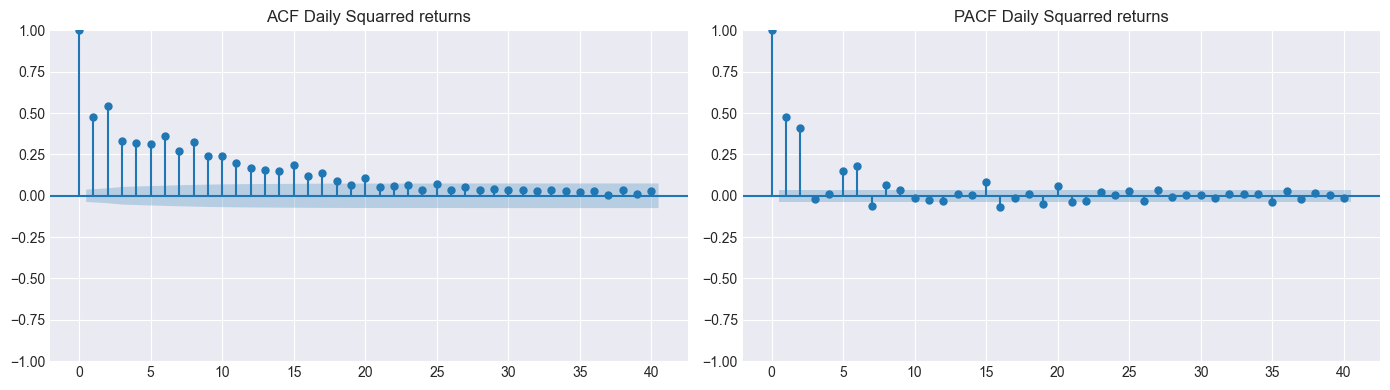

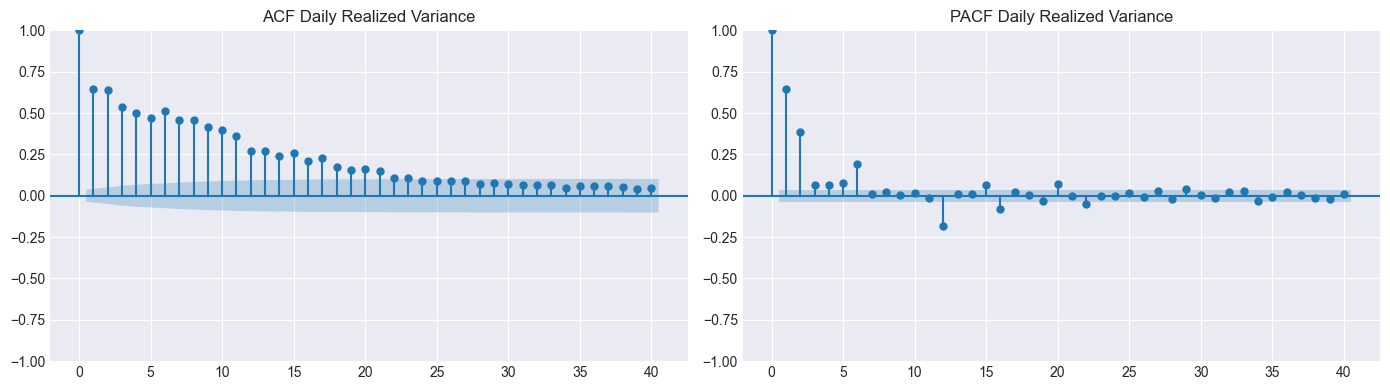

In [27]:
plot_acf_pacf(daily_c2c, lags=40, title="Daily Squarred returns")
plot_acf_pacf(daily_rv, lags=40, title="Daily Realized Variance")

For short horizons, the realized varaicne is more persitent than the close-to-close appromxiated by squarred returns with lags which ate meaningful until 1 months thus we could use autoregressive terms until the 21th to forecast teh next day volatility.

## 3.3 Mean-reverting behaviour

Volatility is mean revrting, namely after a shoch it tends to revrrt slowly towards its uncondtional long term mean.

In [28]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model
model = AutoReg(daily_rv.to_numpy(), lags=1, old_names=False)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2835
Model:                     AutoReg(1)   Log Likelihood               19576.101
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 05 Nov 2025   AIC                         -39146.202
Time:                        09:21:00   BIC                         -39128.354
Sample:                             1   HQIC                        -39139.764
                                 2835                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.869e-05   4.81e-06      8.045      0.000    2.93e-05    4.81e-05
y.L1           0.6461      0.014     45.068      0.000       0.618       0.674
                                    Roots           

The regression coefficient sugguest that the variance has mean-reverting property that can be leveraged in autoregression mdoel like **GARCH**

## 3.4 Volatility distributions are often log-normal

Volatility is strictly positive, highly right-skewed, and empirically close to **log-normal**.  
In other words, while raw volatility (RV, IV) has a heavy-tailed distribution,  
its logarithm is much closer to Normal.

**Modeling benefits:**
- **Positivity:** By modeling log-volatility and exponentiating back, forecasts are guaranteed ≥ 0.  
- **Better fit:** Log-volatility is closer to Gaussian → forecast errors are more symmetric and homoscedastic.  
- **Statistical validity:** Standard linear models (ARMA, HAR-RV, regressions) work more reliably on log-volatility.  

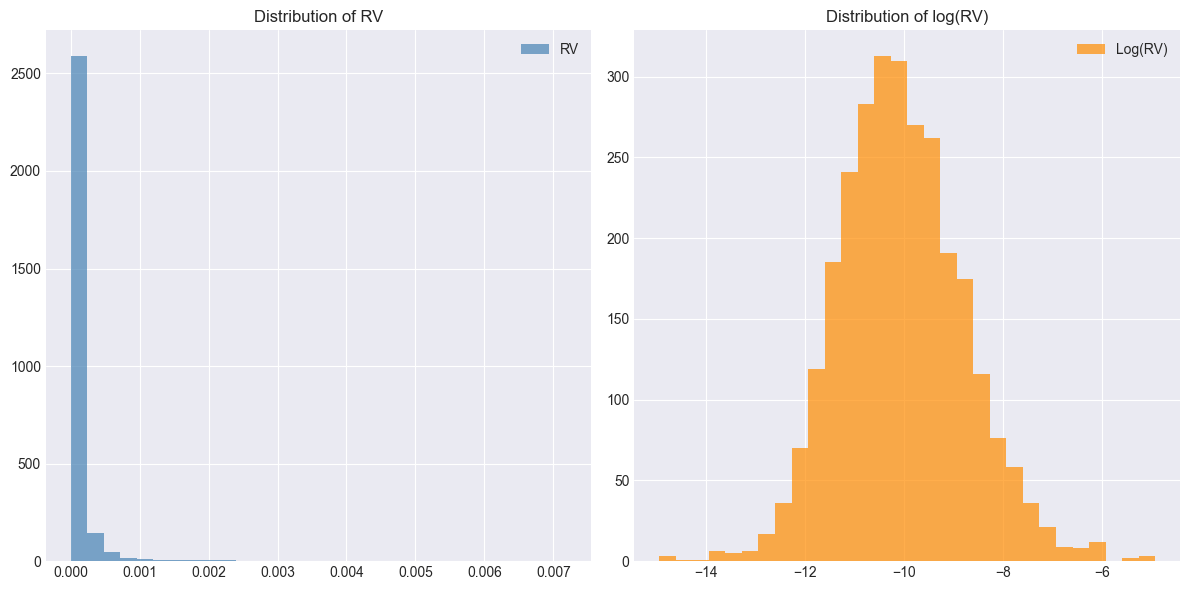

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

daily_rv.hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of RV")
axes[0].legend()

np.log(daily_rv).hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of log(RV)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.5 Asymmetry / Leverage Effect

Another key stylized fact is the **asymmetric relation between returns and volatility**:  
- Negative returns (price drops) tend to increase future volatility more than positive returns of the same magnitude.  
- This is often called the **leverage effect**, since a fall in equity prices increases financial leverage, making the firm riskier.  
- In practice, this creates an asymmetric volatility–return correlation:
  - Correlation between returns and future volatility < 0.

**Modeling implications:**
- Symmetric models (e.g., standard GARCH) cannot capture this.  
- Asymmetric extensions such as EGARCH, GJR-GARCH, or stochastic volatility with leverage are used to account for it.  

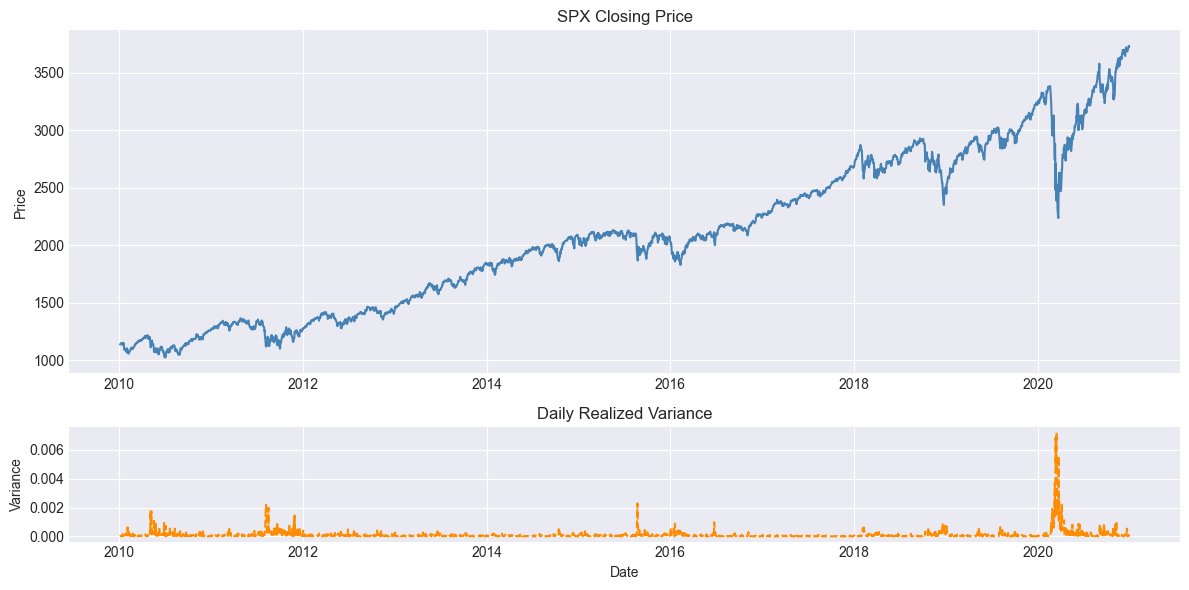

In [31]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # top 3x bigger than bottom

# Top: SPX closing price
ax1 = fig.add_subplot(gs[0])
ax1.plot(spx.index, spx["Close"], color="steelblue")
ax1.set_title("SPX Closing Price")
ax1.set_ylabel("Price")

# Bottom: realized volatility
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_rv.index, daily_rv, color="darkorange", linestyle="--")
ax2.set_title("Daily Realized Variance")
ax2.set_ylabel("Variance")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

Here we can see that durign stress regimes voalitltiy tend to spike.


---

# **4. Problem Formulation**

We frame the task as a supervised learning problem: forecasting the 21-day forward realized volatility of the S&P 500.

Formally, the objective is to predict forward realized volatility using only information available at time $t$.  

$$
y_t = f(X_t; \beta) + \varepsilon_t, \quad \text{with } \mathbb{E}[y_t | X_t] = f(X_t; \beta)
$$

where:
- $y_t$ = target variable (forward 21-day realized volatility),
- $X_t$ = vector of predictors at time $t$.
- $f(.;\beta)$ = parametric or non-parametric form of the regressors


## 4.1 Target Variable: 21-Day Realized Variance

For forecasting purposes, it is convenient to define the target in terms of **daily realized volatility** averaged over the forward horizon.  
This follows the econometric convention (Christoffersen, Corsi, etc.), where multi–day realized volatility is expressed as the mean of daily RVs rather than as total variance.

Since realized variance and volatility are highly skewed and approximately log-normal, we work in the **logarithmic scale**:

$$
y_t = \log\!\big(RV_{t+1:t+21}\big)
$$

where the forward 21-day realized variance aligned at time $t$ is defined as:

$$
RV_{t+1:t+21} 
= \frac{RV_{t+1} + RV_{t+2} + \cdots + RV_{t+21}}{21}
$$

with $RV_{t+i}$ denoting the one-day realized volatility computed from intraday (5-min) returns.

- The **log transform** reduces skewness, stabilizes variance, and makes the distribution closer to Gaussian.  
- It also guarantees positivity when transformed back:

$$
\hat{RV}_{t+1:t+21} = \exp(\hat{y}_t).
$$

In [202]:
def create_forward_target(daily_variance: pd.Series, horizon: int = 21) -> pd.Series:
    """
    daily_variance: per-day realized variance (NOT sqrt, NOT annualized).
                    index = trading days.
    horizon: forecast horizon in trading days (e.g. 21 ~ 1 month).

    Returns:
        y_t = log( average future variance from t+1 to t+horizon )
    """
    # trailing mean, then realign to t as forward mean
    fwd_avg_var = (
        daily_variance
        .rolling(horizon).mean()       # at t+h: mean of [t+1 .. t+h]
        .shift(-horizon)               # move it back so it's aligned at t
    )

    y = np.log(fwd_avg_var)
    y.name = f"log_fwd_var_{horizon}d"
    return y

H = 21
y = create_forward_target(daily_rv, horizon=14)

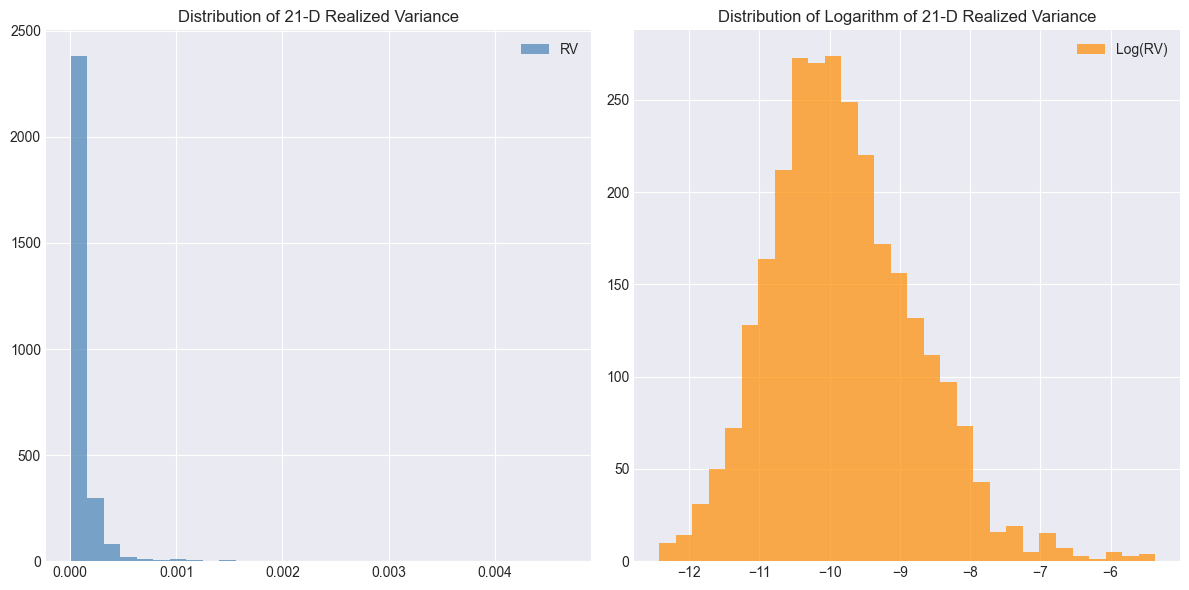

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

np.exp(y).hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of 21-D Realized Variance")
axes[0].legend()

y.hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of Logarithm of 21-D Realized Variance")
axes[1].legend()

plt.tight_layout()
plt.show()

## 4.2 Predictor Families

We use features observable at time (t), grouped into families where each fmailly covers one parituclar aspect of the foward RV.

### 4.2.1 Lagged Volatility Measures: HAR-RV Lags (1D, 5D, 22D)

As seen in the ACF plots, realized variance exhibits strong persistence, remaining significant up to at least 21 lags. This motivates the use of **lagged realized variance/volatility** as predictors.

A common specification is the **HAR-RV (Heterogeneous Autoregressive) structure**, which captures short, medium, and long-term memory effects by including daily, weekly, and monthly averages of past realized variance:

$$
X_{t}^{HAR} = RV_{D,t} + RV_{W,t} + RV_{M,t}
$$

where:
- $RV_{D,t} = RV_{t}$ (daily lag, short-term persistence)  
- $RV_{W,t} = \tfrac{1}{5}\sum_{i=0}^{4} RV_{t-i}$ (weekly average, medium-term)  
- $RV_{M,t} = \tfrac{1}{21}\sum_{i=0}^{20} RV_{t-i}$ (monthly average, long-term)  

This formulation smooths noisy daily lags and reflects the heterogeneous behavior of different market participants (daily traders, weekly rebalancers, monthly institutions).

In [113]:
def create_har_lags(real_variance):
    X_har = pd.DataFrame({
        "RV_D": real_variance,                   # yesterday’s daily RV
        "RV_W": real_variance.rolling(5).mean(), # weekly avg of daily RVs
        "RV_M": real_variance.rolling(21).mean() # monthly avg of daily RVs
    })
    return X_har

X_har = create_har_lags(daily_rv)

In [114]:
summary_stats = ['count','mean','std','min','max','skew','kurtosis']

X_har = create_har_lags(daily_rv)
X_har.agg(summary_stats)

,RV_D,RV_W,RV_M
count,2.835000e+03,2831.000000,2815.000000
mean,1.092941e-04,0.000109,0.000110
std,3.170964e-04,0.000263,0.000219
min,3.257165e-07,0.000004,0.000006
max,7.191973e-03,0.004678,0.002556
skew,1.255384e+01,10.254128,7.915824
kurtosis,2.195748e+02,135.858842,74.452912


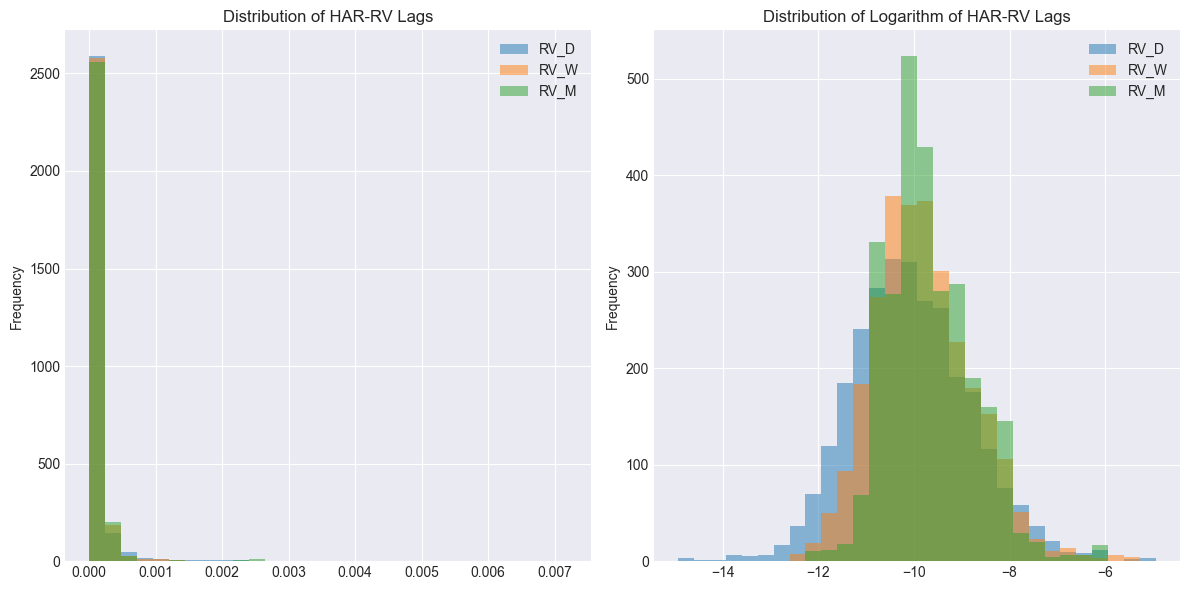

In [1143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

X_har.plot.hist(bins=30, ax=axes[0], label="RV", alpha=0.5)
axes[0].set_title("Distribution of HAR-RV Lags")
axes[0].legend()

np.log(X_har).plot.hist(bins=30, ax=axes[1], label="Log(RV)", alpha=0.5)
axes[1].set_title("Distribution of Logarithm of HAR-RV Lags")
axes[1].legend()

plt.tight_layout()
plt.show()

#### **Transformation Decisions**
- Apply `log` transform to: `RV_D`, `RV_W`, `RV_M`.

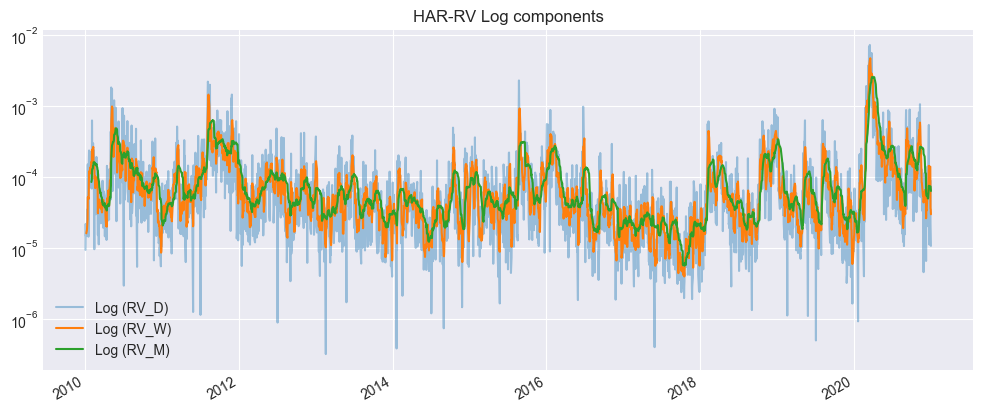

In [115]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_yscale("log")
X_har["RV_D"].plot(ax=ax, alpha=0.4, label="Log (RV_D)")
X_har["RV_W"].plot(ax=ax, alpha=1, label="Log (RV_W)")
X_har["RV_M"].plot(ax=ax, alpha=1, label="Log (RV_M)")
plt.legend(); plt.title("HAR-RV Log components")
plt.show()

In [116]:
def plot_features_vs_target(X, y, log_features=None, figsize=(12, 6), cmap="viridis", nrows=None, ncols=None):
    log_features = log_features or []

    if not ncols:
        n_cols = len(X.columns)
        ncols = 2

    if not nrows:
        nrows = (n_cols + 1) // 2

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, X.columns):
        x = X[col].to_numpy()

        if col in log_features:
            x = np.log(x + 1e-8)  # small offset to avoid log(0)
            x_label = f"log({col})"
        else:
            x_label = col

        hb = ax.hexbin(x, y, gridsize=40, mincnt=1, cmap=cmap)
        ax.set_title(f"{x_label} vs log(y)")
        ax.set_xlabel(x_label)
        ax.set_ylabel("log(y)")
        fig.colorbar(hb, ax=ax, shrink=0.8)

    plt.tight_layout()
    plt.show()

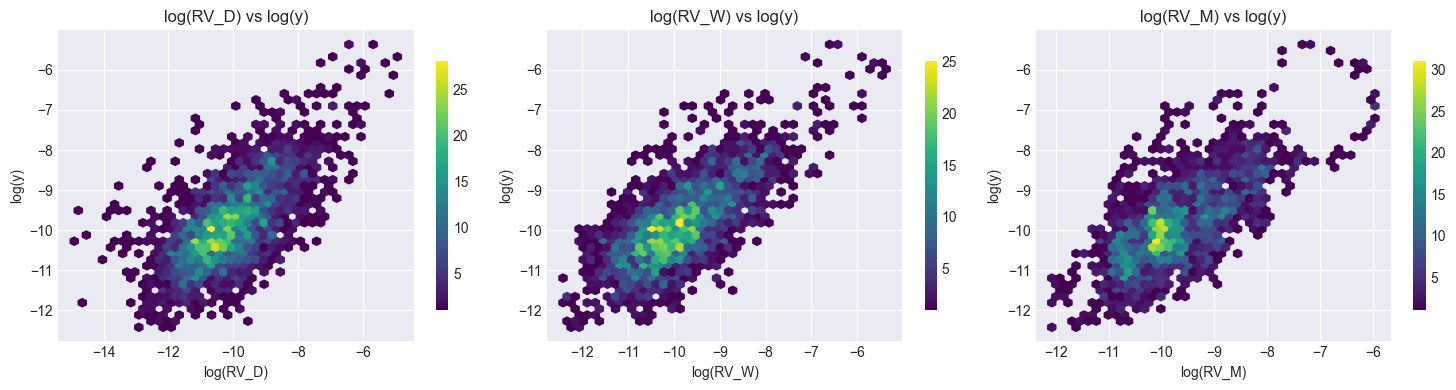

In [117]:
plot_features_vs_target(X_har, y, log_features=X_har.columns.tolist(), figsize=(15, 4), nrows=1, ncols=3)

### 4.2.2 Implied Volatility Signals  

While realized volatility lags capture **persistence**, implied volatility (IV) embeds the market’s **forward-looking expectations** of future volatility and risk premia.  
Here we focus on features derived from the option surface of the underlying we trade:

- **ATM IV (1M maturity)**  
  Near-the-money implied volatility for ~1-month options, closely linked to the traded option premium and less contaminated by skew than indices such as VIX.  

- **25Δ IV Skew (Risk Reversal)**  
  Difference between the 1M 25-delta OTM put IV and the 1M 25-delta OTM call IV.  
  This 25Δ risk-reversal skew serves as a proxy for the **downside risk premium** and crash-protection demand: steeper (more negative) skew typically corresponds to elevated tail-risk pricing.  

- **IV Term Structure**  
  Slope between short- and long-dated IVs (1M vs 3M).  
  An **inverted term structure** (front IV > back IV) typically signals near-term stress, whereas an upward-sloping structure is more consistent with benign or mean-reverting volatility regimes.  

These IV-based predictors complement RV lags by providing a **market-implied view of future volatility**, which is central for constructing IV–RV mispricing signals.

In [124]:
spx_options = pd.read_parquet("data/intermediate/full_spx_options_2010_2020.parquet")

spx_options["T"] = spx_options["dte"] / 252 # Time to expity in years
spx_options["k"] = np.log(
    spx_options["strike"] / spx_options["underlying_last"] # Log-forward moneyness
 )

In [ ]:
def create_iv_surface_predictors(options, iv_surface_model, params=None, r=0.0, q=0.0):
    iv_features = []
    T_30 = 30 / 252
    T_60 = 60 / 252

    for date, chain in options.groupby("date"):
        # --- Underlying spot (ATM anchor) ---
        S = float(chain["underlying_last"].iloc[0])

        # --- Fit or restore the surface ---
        if params is None or date not in params:
            iv_surface_model.fit(chain)
        else:
            iv_surface_model.set_params({**params[date], "spot": S})

        # --- ATM IVs ---
        atm_iv_30d = iv_surface_model.implied_vol(S, T_30)
        atm_iv_60d = iv_surface_model.implied_vol(S, T_60)

        # --- 25Δ strikes (approx using ATM vol for the delta inversion) ---
        # target deltas: put = -0.25, call = +0.25
        K_put_25d = solve_strike_for_delta(
            target_delta=-0.25,
            S=S,
            T=T_30,
            sigma=atm_iv_30d,
            option_type="put",
            r=r,
            q=q
        )
        K_call_25d = solve_strike_for_delta(
            target_delta=0.25,
            S=S,
            T=T_30,
            sigma=atm_iv_30d,
            option_type="call",
            r=r,
            q=q
        )

        # --- 25Δ skew (downside - upside) ---
        iv_put_25d = iv_surface_model.implied_vol(K_put_25d, T_30)
        iv_call_25d = iv_surface_model.implied_vol(K_call_25d, T_30)
        iv_skew = iv_put_25d - iv_call_25d

        # --- Term structure slope (30D → 60D) ---
        iv_ts = atm_iv_60d - atm_iv_30d

        iv_features.append({
            "date": date,
            "atm_iv_30d": atm_iv_30d,
            "iv_skew": iv_skew,
            "iv_ts": iv_ts,
        })

    iv_features = pd.DataFrame(iv_features).set_index("date").sort_index()
    return iv_features

In [1149]:
ssvi = SSVI()
df_g = pd.read_parquet("ssvi_globals_2010_2020.parquet")
df_k = pd.read_parquet("ssvi_knots_2010_2020.parquet")

params_ssvi = ssvi.build_params_dict(df_g, df_k)
X_iv_surface = create_iv_surface_predictors(spx_options, ssvi, params=params_ssvi)
X_iv_surface = X_iv_surface.reindex(y.index).ffill()

#### Correct data error from iv puts

In [1150]:
X_iv_surface.loc["2019-05-02":"2019-05-08", :] = np.nan
X_iv_surface.loc["2019-05-17", :] = np.nan
X_iv_surface = X_iv_surface.interpolate(method="linear")

X_iv_surface.agg(summary_stats)

,atm_iv_30d,iv_skew,iv_ts
count,2835.000000,2835.000000,2835.000000
mean,0.149376,0.067752,0.007421
std,0.066764,0.029388,0.011248
min,0.062058,0.024176,-0.087146
max,0.776023,0.429290,0.080241
skew,2.618590,3.522620,-1.728868
kurtosis,12.771528,25.062136,12.562780


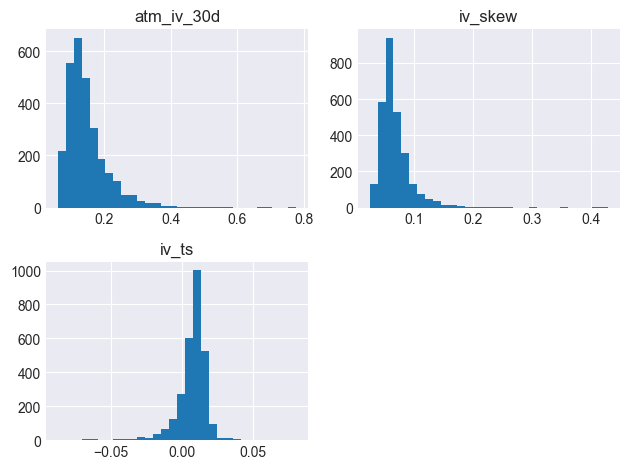

In [1151]:
X_iv_surface.hist(bins=30)
plt.tight_layout()
plt.show()

#### **Transformation Decisions**
- Apply `log` transform to: `iv_atm_60`, `iv_skew`.
- Apply Yeo-Johnson transform to: `iv_ts`

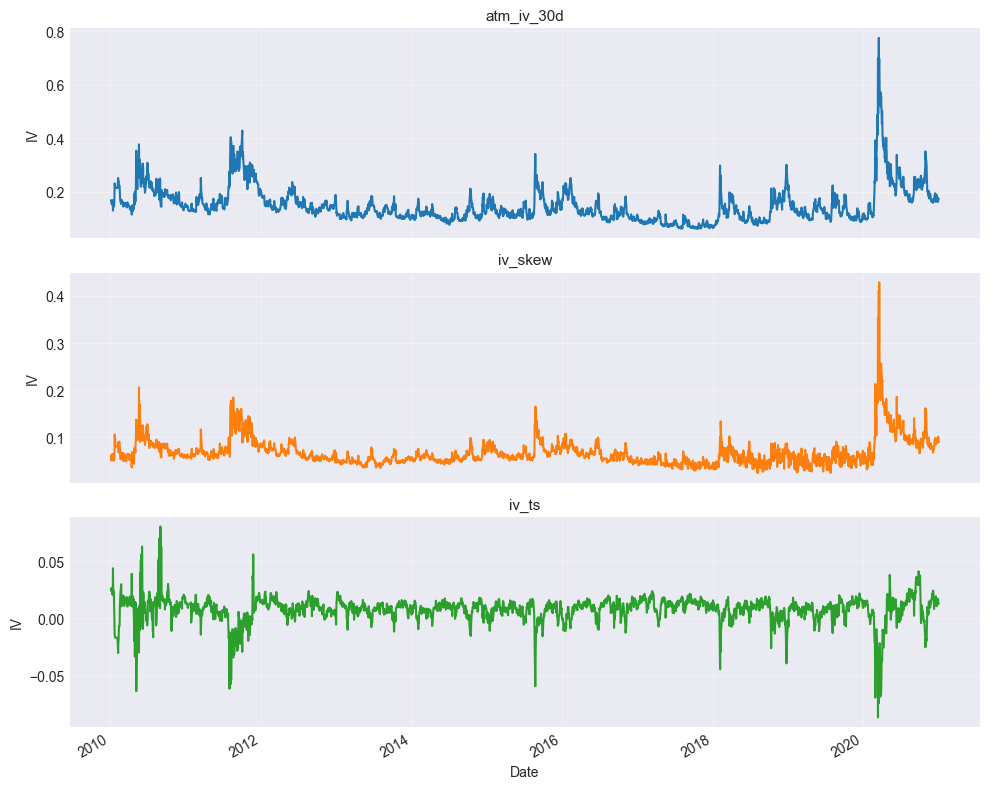

In [1152]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green, red

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for ax, col, c in zip(axes.flat, X_iv_surface.columns, colors):
    X_iv_surface[col].plot(ax=ax, lw=1.5, color=c)
    ax.set_title(col, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Date")
    ax.set_ylabel("IV")
    
plt.tight_layout()
plt.show()

During market crashes the IV spike, skew steepens, the Iv-term strcutrue gets inverted.

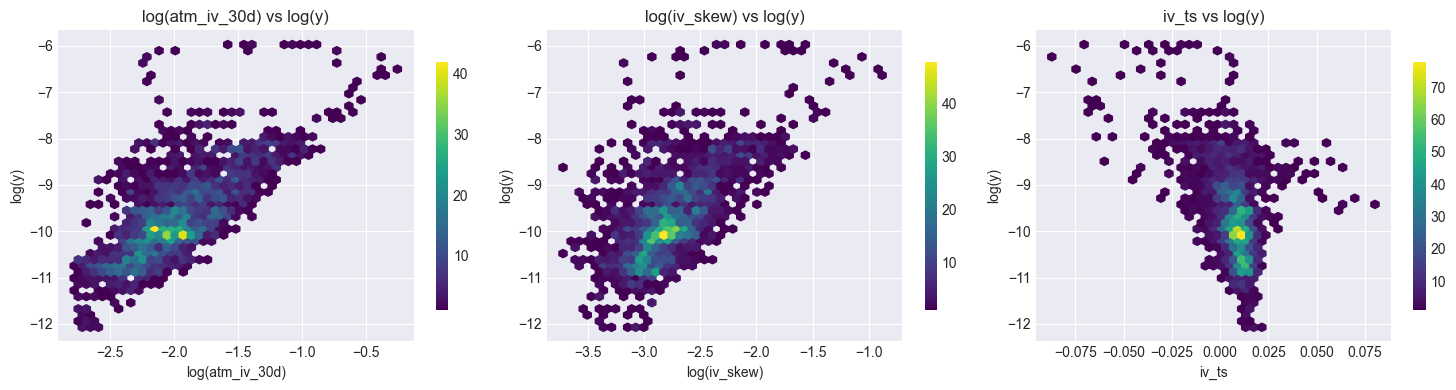

In [1161]:
plot_features_vs_target(X_iv_surface, y, log_features=["atm_iv_30d", "iv_skew"], figsize=(15,4), nrows=1, ncols=3)

### 4.2.3 Return-based Predictors  

Return-based predictors are essential for volatility: large moves in returns often coincide with large moves in volatility.  
However, daily returns are very noisy and our target is **21-day RV**, so we use **short rolling windows** (e.g. 5 trading days) to extract more stable signals.

- **Jumps (overnight moves)**  
  Large overnight returns (close\_{t−1} → open\_t) often coincide with news events and gap risk.  

- **Volatility clustering / persistence**  
  Rolling means of **absolute** and **squared** returns summarize the recent volatility regime.  

- **Asymmetry / leverage effect**  
  Periods dominated by large negative moves typically forecast **higher future RV** than periods with similar variance coming from positive moves.

- **Shape of the return distribution**  
  Rolling **realized skewness** and **kurtosis** capture asymmetry and tail thickness of recent returns which often coincides with stressed markets and higher forward volatility.

In [1307]:
def overnight_return(df, rth_start="09:30", rth_end="16:00"):
    """
    df: 5-min ES OHLCV with DatetimeIndex (exchange timezone)
    r_ov_t = log( Open_RTH_t / Close_RTH_{t-1} )
    """
    tod = df.index.strftime("%H:%M")
    rth = df[(tod >= rth_start) & (tod <= rth_end)].copy()

    # RTH open = first 'open' of the day, RTH close = last 'close' of the day
    daily_open  = rth.groupby(rth.index.date)["open"].first()
    daily_close = rth.groupby(rth.index.date)["close"].last()

    daily_open.index  = pd.to_datetime(daily_open.index)
    daily_close.index = pd.to_datetime(daily_close.index)

    ov = np.log(daily_open / daily_close.shift(1))
    ov.name = "overnight_ret"
    return ov.dropna()

def create_return_predictors(daily_returns: pd.Series, intraday_prices: pd.Series, h: int = 21) -> pd.DataFrame:
    ret_features = pd.DataFrame(index=daily_returns.index)

    # --- Overnight weekly overnihgt returns (jumps) ---
    ret_features["overnight_ret"] = overnight_return(intraday_prices).rolling(5).mean()

    # --- Volatility clustering ---
    ret_features["abs_r"] = daily_returns.abs().rolling(5).mean()
    ret_features["r2"] = daily_returns.pow(2).rolling(5).mean()

    # --- Asymmetry / leverage ----
    is_neg_ret = (daily_returns < 0).astype(int)
    ret_features["neg_r2"] = (is_neg_ret * ret_features["r2"]).rolling(5).mean()

    # --- Downside vs upside semivariance ---
    rolling = daily_returns.rolling(h)
    ret_features["down_var"] = rolling.apply(
        lambda x: (np.minimum(x, 0.0) ** 2).mean(), raw=False
    )
    ret_features["up_var"] = rolling.apply(
        lambda x: (np.maximum(x, 0.0) ** 2).mean(), raw=False
    )

    # --- Realized skewness & kurtosis ---
    ret_features["skew"] = rolling.apply(lambda x: ((x / x.std())**3).mean(), raw=False)
    ret_features["kurt"] = rolling.apply(lambda x: ((x / x.std())**4).mean(), raw=False)

    return ret_features

In [1308]:
X_returns = create_return_predictors(spx["returns"], es_5min, h=H)
X_returns = X_returns.reindex(y.index).ffill()
X_returns.agg(summary_stats)

,overnight_ret,abs_r,r2,neg_r2,down_var,up_var,skew,kurt
count,2830.000000,2830.000000,2.830000e+03,2826.000000,2.813000e+03,2813.000000,2813.000000,2813.000000
mean,0.000306,0.007043,1.217114e-04,0.000057,6.564926e-05,0.000057,0.191340,3.408498
std,0.003318,0.006107,3.871663e-04,0.000197,1.870573e-04,0.000124,0.992732,1.400154
min,-0.030006,0.000581,3.711225e-07,0.000000,4.745243e-07,0.000003,-3.208464,1.457295
max,0.023852,0.085571,8.078781e-03,0.004156,2.249933e-03,0.001509,3.399189,13.121545
skew,-0.408708,4.938071,1.351947e+01,13.307585,9.039184e+00,8.188091,0.199356,1.840437
kurtosis,9.990675,43.773244,2.319493e+02,218.484532,9.238763e+01,77.965242,-0.182521,5.160144


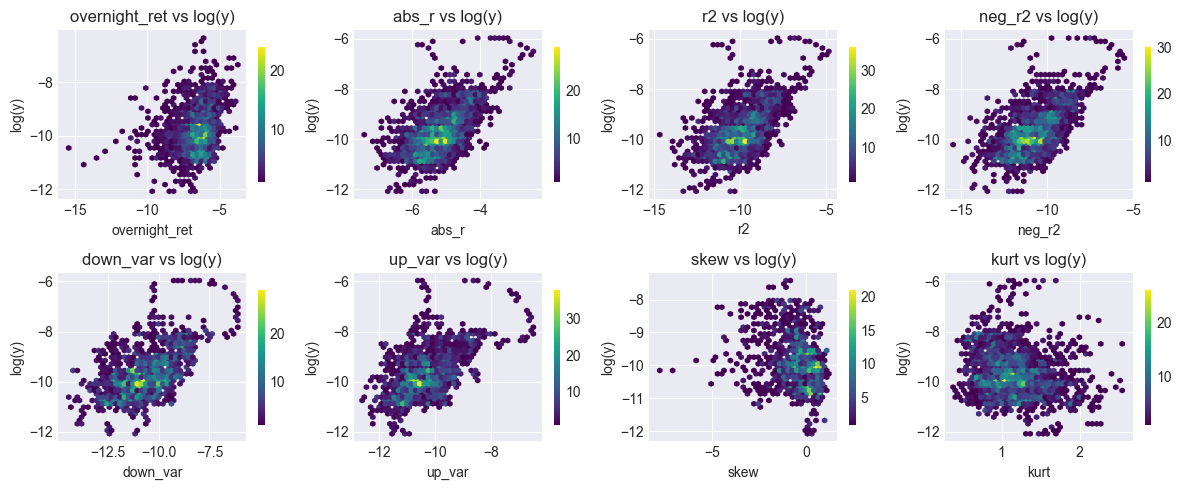

In [1323]:
plot_features_vs_target(np.log(X_returns), y, log_features=None, figsize=(12, 5), nrows=2, ncols=4)

### 4.2.4 Macro & Market Predictors  

This category combines **macro fundamentals** (rates, credit spreads) with **market-based measures** (volume, liquidity, realized correlations).  
Though generally less predictive than RV lags or IV signals, they can add value in stress regimes and are well suited to **machine learning models**, which can exploit non-linearities across a broader set of features.

#### Macro Fundamentals  

Here we include **slow-moving economic and financial variables** that capture the broader macro environment.  
These are unlikely to explain day-to-day fluctuations in volatility but may contain information about **regime shifts** (e.g. monetary tightening, credit stress) that affect forward realized volatility:  

- **Interest rate levels & term spreads**: Treasury yields (e.g. 3M, 2Y, 10Y), slope of the yield curve.  
- **Credit spreads**: Investment-grade and high-yield spreads, proxies for systemic financial stress.  

These predictors move more slowly than market-based signals but help identify **macro-driven volatility regimes** (e.g. high-rate environments, credit crises).

In [ ]:
# --- Load FRED API key from environment ---
load_dotenv()
FRED = None
try:
    from fredapi import Fred
    api_key = os.getenv("FRED_API_KEY")  # loaded from .env or system env
    if api_key:
        FRED = Fred(api_key=api_key)
        print("FRED API loaded.")
    else:
        print("No FRED API key found in environment. Macro features will be empty.")
except ImportError:
    print("fredapi not installed. Install with `pip install fredapi`.")

# --- Helper to fetch a single FRED series ---
def _fred_series(series_id, start=None, end=None):
    if FRED is None:
        return pd.Series(dtype=float, name=series_id)
    s = FRED.get_series(series_id, observation_start=start, observation_end=end)
    s = pd.Series(s, name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

# --- Main macro feature builder ---
def create_macro_features(start="2005-01-01", end=None):
    # --- Treasury yields ---
    DGS10  = _fred_series("DGS10",  start, end).rename("DGS10")   # 10Y yield (%)
    DGS2   = _fred_series("DGS2",   start, end).rename("DGS2")    # 2Y yield (%)
    DGS3MO = _fred_series("DGS3MO", start, end).rename("DGS3MO")  # 3M yield (%)
    term_spread = (DGS10 - DGS3MO).rename("term_spread_10y_3m")

    # --- Credit spreads ---
    HY_OAS = _fred_series("BAMLH0A0HYM2", start, end).rename("HY_OAS")   # High Yield OAS (%)
    IG_OAS = _fred_series("BAMLC0A0CM",   start, end).rename("IG_OAS")   # IG OAS (%)

    df = pd.concat([DGS10, DGS2, DGS3MO, term_spread, HY_OAS, IG_OAS], axis=1).sort_index()

    # Business-day frequency; forward-fill for sparse macro data
    df = df.asfreq("B")
    df = df.ffill()

    return df

FRED API loaded.


In [58]:
X_macro = create_macro_features(start=start, end=end)

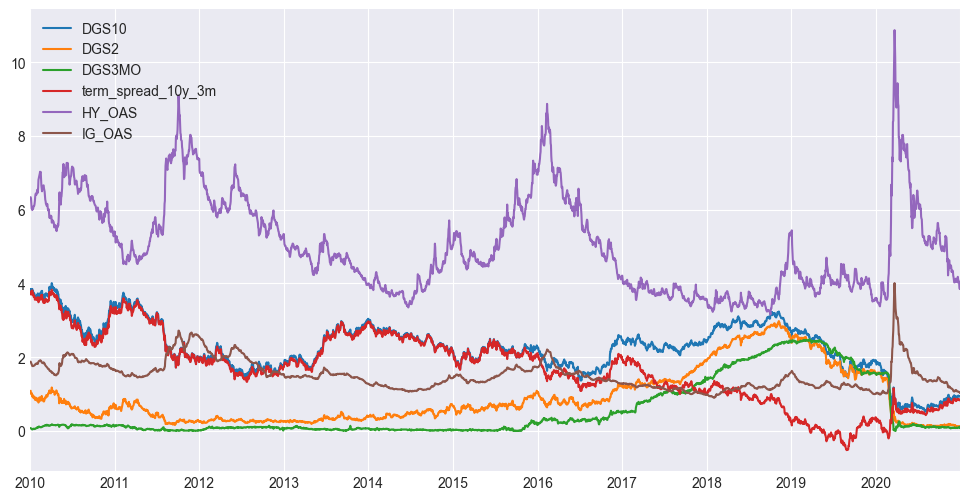

In [59]:
X_macro.plot(figsize=(12, 6))
plt.show()

In [60]:
X_macro.agg(summary_stats)

,DGS10,DGS2,DGS3MO,term_spread_10y_3m,HY_OAS,IG_OAS
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000
mean,2.266386,0.909913,0.557640,1.708745,5.045852,1.507881
std,0.691805,0.747697,0.777146,0.958607,1.277921,0.387046
min,0.520000,0.110000,0.000000,-0.520000,3.160000,0.900000
max,4.010000,2.980000,2.490000,3.830000,10.870000,4.010000
skew,-0.240419,1.157739,1.337855,-0.083195,0.777234,1.348940
kurtosis,0.193617,0.237751,0.238467,-0.607180,0.097309,2.859696


In [62]:
X_macro = X_macro.reindex(y.index).ffill()

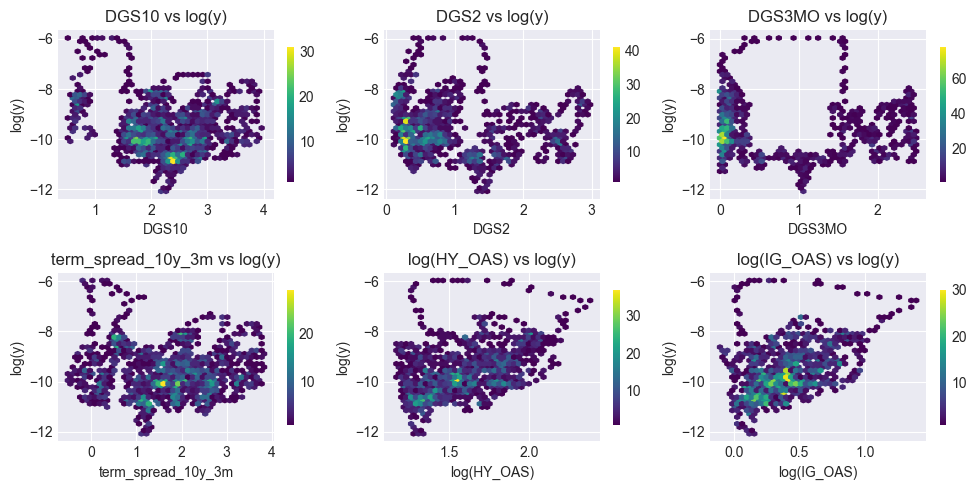

In [63]:
plot_features_vs_target(X_macro, y, log_features=["HY_OAS", "IG_OAS"], figsize=(10, 5), nrows=2, ncols=3)

In the 0 rates environment observed since the, short term interrest arets `DGS3MO` was mainly 0 up til `2017`so we decide to drop it.

In [1195]:
X_macro = X_macro.drop("DGS3MO", axis=1)

#### Market / Sentiment  

Here we include **market-implied and positioning-based indicators** that reflect how “nervous” or “complacent” investors are.  
They react faster than macro variables and can help identify **risk-on / risk-off regimes**, which affect both the level and persistence of future realized volatility:  

- **VIX**: benchmark measure of 30-day implied volatility on the S&P 500; a fast-moving barometer of market fear and near-term uncertainty.  
- **VVIX**: “volatility of volatility” index, capturing how uncertain the market is about future changes in VIX itself; often spikes in unstable vol regimes.  

These variables do not directly describe the asset’s own volatility process but provide **high-frequency information about crowd risk appetite**, making them natural **filters or conditioning variables** for IV–RV mispricing signals.

In [1233]:
def create_market_features(start: str, end: str) -> pd.DataFrame:
    vix = yf.download(["^VIX", "^VVIX"], start=start, end=end, auto_adjust=True, progress=False)[["Close"]]
    vix.columns = [tkr.replace("^", "") for _, tkr in vix.columns]
    vix = vix.rename(columns={"VIX": "VIX", "VVIX": "VVIX"}).sort_index()
    return vix

In [1234]:
X_market = create_market_features(start=start, end=end)
X_market = X_market.reindex(y.index).ffill()

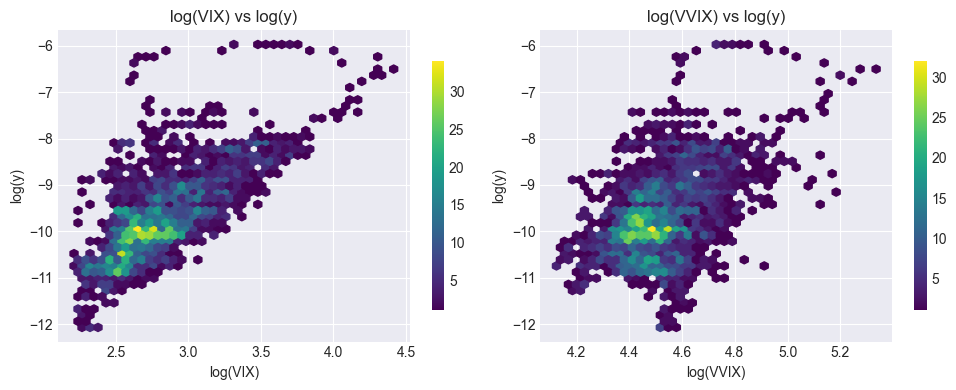

In [1240]:
plot_features_vs_target(X_market, y, log_features=["VIX", "VVIX"], figsize=(10, 4))

# **5. Feature Engineering**

We go beyond raw predictors (HAR lags, VIX, IV surface, credit spreads, etc.) by creating features that are more aligned with the forecasting task. The goal is to reduce noise, capture regime levels, and detect stress transitions that precede volatility spikes.  

- **Horizon-aligned smoothing:** The target is 21-day forward realized variance, so daily predictors are too noisy. We create regime-level signals that capture persistent volatility regimes instead of one-day noise.  

- **Regime shift / stress dynamics:** Volatility surges usually follow abrupt risk repricing. To capture this we add regime change features like momentum in VIX and SKEW as well as intercation effects like VVIX and VIX.

In [1354]:
def feature_engineering(
    X_core: pd.DataFrame,
    window_short: int = 5,
    window_long: int = 21,
    ewma_alpha: float = 0.2,
) -> pd.DataFrame:
    """
    Create X_eng features from economic predictors.
    Returns ONLY the X_eng features (not X_core itself).
    """
    X = X_core.copy()
    X_eng = {}

    # -------------------------------------------------
    # 1. Horizon-aligned smoothing (regime level)
    # -------------------------------------------------
    if "VIX" in X:
        X_eng["VIX_rm5"]   = X["VIX"].rolling(window_short, min_periods=1).mean()
        X_eng["VIX_rm21"]  = X["VIX"].rolling(window_long, min_periods=1).mean()
        X_eng["VIX_ewma"]  = X["VIX"].ewm(alpha=ewma_alpha, adjust=False).mean()

    if "RV_D" in X:
        X_eng["RV_D_ewma"] = X["RV_D"].ewm(alpha=ewma_alpha, adjust=False).mean()

    if "HY_OAS" in X:
        X_eng["HY_OAS_ewma"] = X["HY_OAS"].ewm(alpha=ewma_alpha, adjust=False).mean()

    # -------------------------------------------------
    # 2. Regime shift / stress dynamics
    # -------------------------------------------------
    if "VIX" in X:
        X_eng["dVIX_5d"] = X["VIX"] - X["VIX"].shift(window_short)

    if "iv_skew" in X:
        X_eng["dSkew_5d"] = X["iv_skew"] - X["iv_skew"].shift(window_short)

    if "atm_iv_30d" in X and "RV_M" in X:
        X_eng["iv_minus_realized"] = X["atm_iv_30d"] - X["RV_M"]

    if "VVIX" in X and "VIX" in X:
        X_eng["vvix_over_vix"] = X["VVIX"] / X["VIX"].replace(0, np.nan)

    if "VIX" in X and "HY_OAS" in X:
        X_eng["VIX_time_HY_OAS"] = X["VIX"] * X["HY_OAS"] 
    
    if "RV_D" in X:
        X_eng["RV_D_rollvol5"] = X["RV_D"].rolling(5).std()
        X_eng["RV_D_rollvol21"] = X["RV_D"].rolling(21).std()

    # -------------------------------------------------
    # 3. Assemble into DataFrame
    # -------------------------------------------------
    X_eng = pd.DataFrame(X_eng, index=X.index)

    return X_eng

In [ ]:
X_core = pd.concat([X_har, X_iv_surface, X_macro, X_returns, X_market], axis=1)
X_eng = feature_engineering(X_core)
X = pd.concat([X_core, X_eng], axis=1)
X = X.dropna(axis=0)

core_features = X_core.columns.tolist()
eng_features = X_eng.columns.tolist()

X_eng.agg(summary_stats)

,VIX_rm5,VIX_rm21,VIX_ewma,RV_D_ewma,HY_OAS_ewma,dVIX_5d,dSkew_5d,iv_minus_realized,vvix_over_vix,VIX_time_HY_OAS,RV_D_rollvol5,RV_D_rollvol21
count,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2830.000000,2830.000000,2815.000000,2835.000000,2835.000000,2831.000000,2815.000000
mean,17.971053,17.960360,17.969347,0.000109,5.049248,0.005693,0.000061,0.149081,5.655410,97.091306,0.000081,0.000109
std,7.259670,6.853001,7.046994,0.000240,1.263522,3.593055,0.018515,0.066756,1.435551,68.567904,0.000181,0.000209
min,9.376000,9.800000,9.614762,0.000004,3.233705,-21.100002,-0.225512,0.062051,2.054459,30.979201,0.000001,0.000003
max,74.618001,61.258572,65.811602,0.003825,9.377609,35.850002,0.234780,0.774351,10.316940,707.040000,0.002710,0.002145
skew,2.536454,2.301621,2.402397,9.136190,0.713000,1.683577,1.018086,2.616658,0.373912,3.348497,8.036214,6.563821
kurtosis,10.793452,8.074845,9.234084,104.384005,-0.209626,14.954005,37.015940,12.701030,0.257500,18.603871,86.449242,52.444094


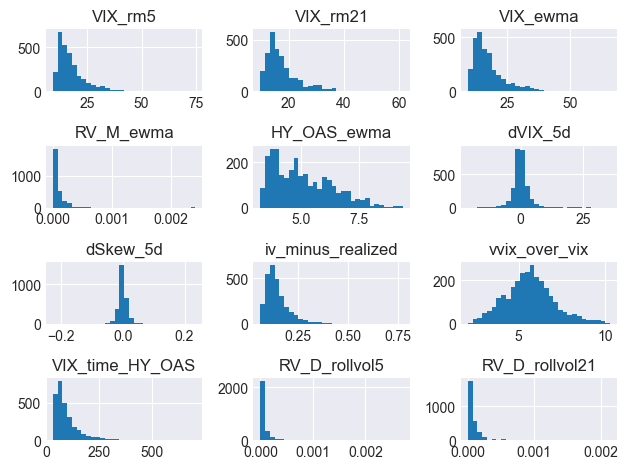

In [1243]:
X_eng.hist(bins=30)
plt.tight_layout()
plt.show()

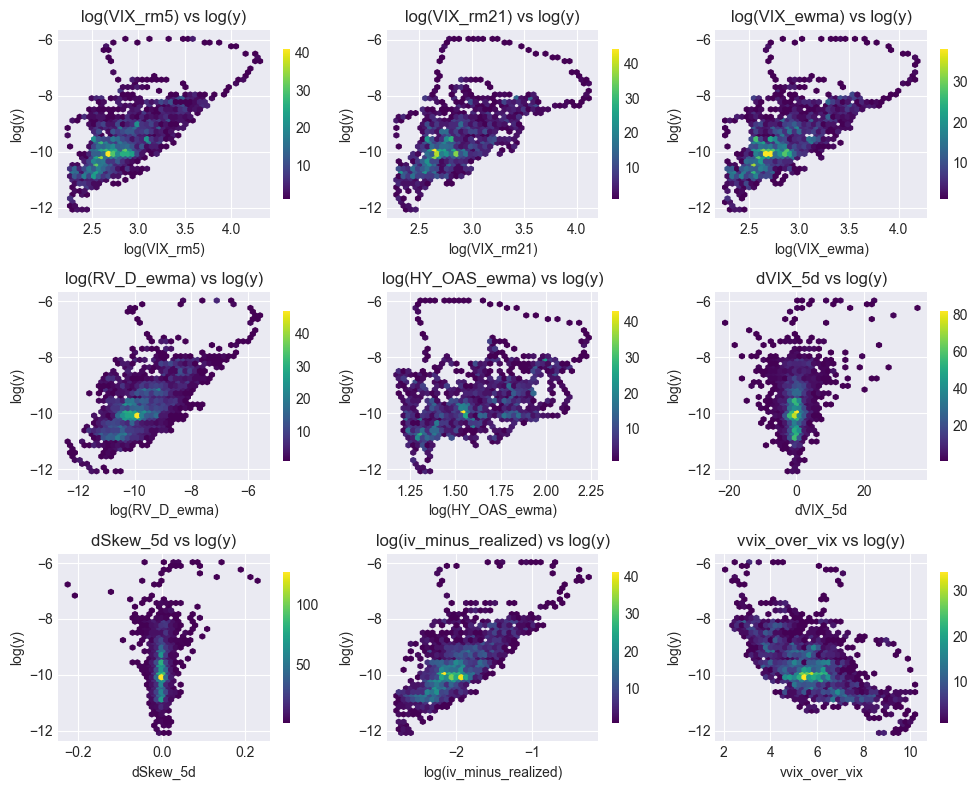

In [1338]:
plot_features_vs_target(X_eng, y, log_features=list(set(eng_features) - set(["dVIX_5d", "dSkew_5d", "vvix_over_vix"])), figsize=(10, 8), nrows=3, ncols=3)

In [1939]:
del (X_har, X_iv_surface, X_macro, X_returns, X_market, X_core, X_eng)

# **6. Data Preprocessing**

We inspect each predictor’s distribution (shape, skewness, tail heaviness) and only transform when necessary.  
The goal is to make features more symmetric and well-behaved for regression and machine learning.

We rely on simple, interpretable transforms:

- **log** for strictly positive, heavy-right-tailed variables (e.g. VIX, kurtosis proxies),
- **sqrt** for variance-like or squared quantities (e.g. squared returns),
- **winsorization** (clipping extreme quantiles) to tame rare but extreme outliers.
- **scaling** apply standard scaling to put all the features on the same scale (essential for linear models)

This step is not about “cheating the target,” but about stabilizing scale and reducing extreme tails so the model trains on cleaner signals.  
Since most predictors are already smoothed (HAR averages, rolling VIX, EWMA spreads, etc.), we mainly need to correct **heavy right tails** and **occasional extreme shocks** rather than aggressively reshape every feature.

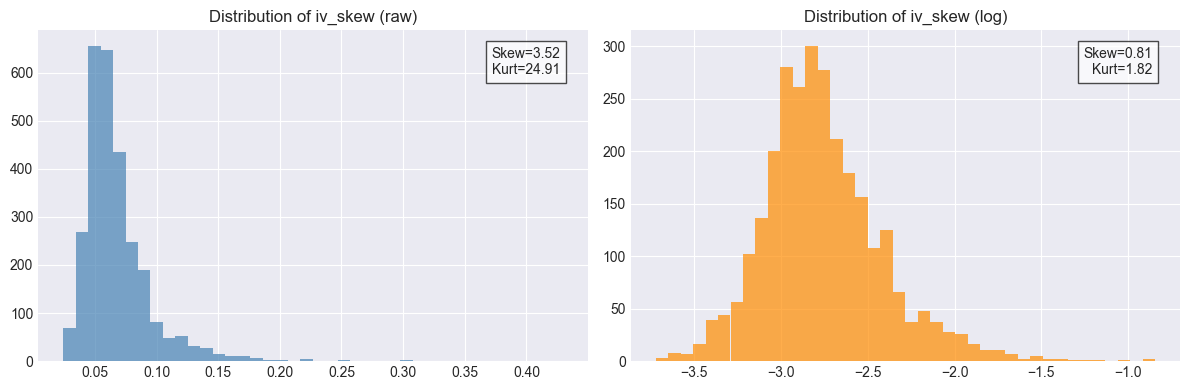

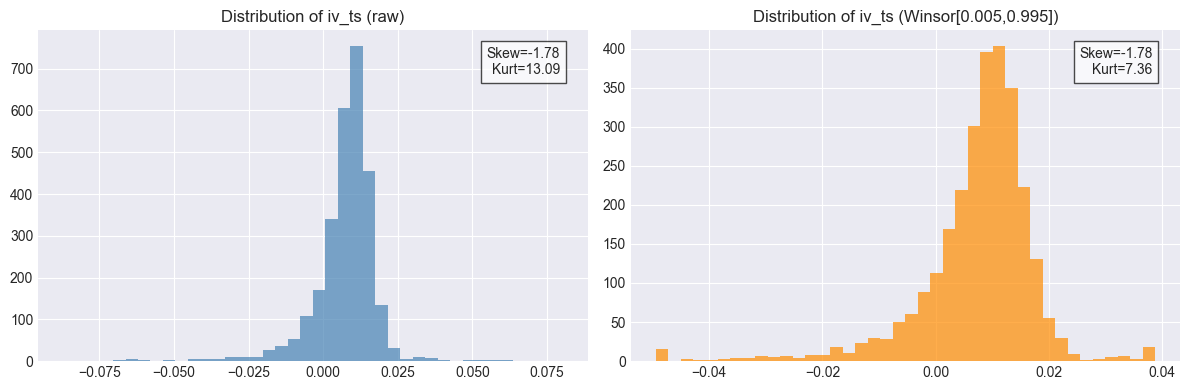

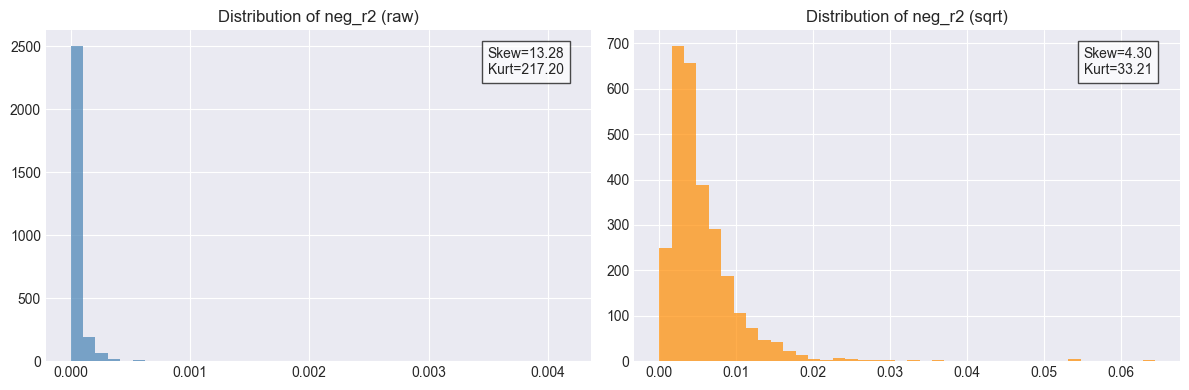

In [1422]:
ph.plot_transform_demo(X["iv_skew"], use_log=True)
ph.plot_transform_demo(X["iv_ts"], winsorize=(0.005, 0.995))
ph.plot_transform_demo(X["neg_r2"], use_sqrt=True)

## Data processsing pipeline

In [2293]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, eps=1e-8):
        self.eps = eps

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.log(np.clip(X, self.eps, None))

    def set_output(self, *, transform=None):
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f"feature_{i}" for i in range(self.n_features_in_)])
        # keep original names
        return np.asarray(input_features, dtype=str)


class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.n_features_in_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.sqrt(np.clip(X, 0.0, None))

    def set_output(self, *, transform=None):
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f"feature_{i}" for i in range(self.n_features_in_)])
        # keep original names
        return np.asarray(input_features, dtype=str)


class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.005, upper=0.995):
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_ = np.quantile(X, self.lower, axis=0)
        self.q_high_ = np.quantile(X, self.upper, axis=0)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)

    def set_output(self, *, transform=None):
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f"feature_{i}" for i in range(self.n_features_in_)])
        # keep original names
        return np.asarray(input_features, dtype=str)


class DataProcessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 log_features=None,
                 sqrt_features=None,
                 winsor_features=None,
                 winsor_sqrt_features=None,
                 scale=True):
        """
        log_features: list of cols → log only
        sqrt_features: list of cols → sqrt only
        winsor_features: list of ( [low, high], [col1, col2, ...] ) → winsor only
        winsor_sqrt_features: list of ( [low, high], [col1, col2, ...] )
            → winsorize, then sqrt

        Each feature must appear in at most ONE of:
        - log_features
        - sqrt_features
        - any winsor_features group
        - any winsor_sqrt_features group
        Others are passed through unchanged.
        """
        self.log_features = [] if log_features is None else log_features
        self.sqrt_features = [] if sqrt_features is None else sqrt_features
        self.winsor_features = [] if winsor_features is None else winsor_features
        self.winsor_sqrt_features = [] if winsor_sqrt_features is None else winsor_sqrt_features
        self.scale = scale

        self.preprocessor_ = None
        self.pipeline_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        all_cols = list(X_df.columns)

        # intersect lists with actual columns
        log_cols = [c for c in self.log_features if c in all_cols]
        sqrt_cols = [c for c in self.sqrt_features if c in all_cols]

        winsor_features_clean = []
        for (q_range, cols) in self.winsor_features:
            cols_present = [c for c in cols if c in all_cols]
            winsor_features_clean.append((q_range, cols_present))

        winsor_sqrt_features_clean = []
        for (q_range, cols) in self.winsor_sqrt_features:
            cols_present = [c for c in cols if c in all_cols]
            winsor_sqrt_features_clean.append((q_range, cols_present))

        # collect all winsor columns actually present
        winsor_cols_all = []
        for (q_range, cols) in winsor_features_clean:
            winsor_cols_all.extend(cols)

        winsor_sqrt_cols_all = []
        for (q_range, cols) in winsor_sqrt_features_clean:
            winsor_sqrt_cols_all.extend(cols)

        used = (
            set(log_cols)
            | set(sqrt_cols)
            | set(winsor_cols_all)
            | set(winsor_sqrt_cols_all)
        )
        passthrough_cols = [c for c in all_cols if c not in used]

        transformers = []

        if log_cols:
            transformers.append(("log", LogTransformer(), log_cols))

        if sqrt_cols:
            transformers.append(("sqrt", SqrtTransformer(), sqrt_cols))

        for (q_range, cols) in winsor_features_clean:
            if not cols:
                continue
            low, high = q_range
            name = f"winsor_{low}_{high}".replace(".", "p")
            transformers.append((name, Winsorizer(lower=low, upper=high), cols))

        for (q_range, cols) in winsor_sqrt_features_clean:
            if not cols:
                continue
            low, high = q_range
            name = f"winsor_sqrt_{low}_{high}".replace(".", "p")
            ws_pipeline = Pipeline([
                ("winsor", Winsorizer(lower=low, upper=high)),
                ("sqrt", SqrtTransformer()),
            ])
            transformers.append((name, ws_pipeline, cols))

        if passthrough_cols:
            transformers.append(("passthrough", "passthrough", passthrough_cols))

        self.preprocessor_ = ColumnTransformer(
            transformers=transformers,
            remainder="drop",
            verbose_feature_names_out=False,
        )

        steps = [("preprocess", self.preprocessor_)]
        if self.scale:
            steps.append(("scaler", StandardScaler()))

        self.pipeline_ = Pipeline(steps)
        self.pipeline_.fit(X_df, y)

        try:
            self.feature_names_out_ = self.preprocessor_.get_feature_names_out()
        except AttributeError:
            self.feature_names_out_ = None

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        return self.pipeline_.transform(X_df)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def get_feature_names_out(self):
        return self.feature_names_out_

## Apply the appropiate transformations

In [2209]:
log_features = [
    "RV_D", "RV_W", "RV_M", "RV_D_ewma",
    "abs_r", "r2", "down_var", "up_var", "skew", "kurt",
    "VIX", "VVIX", "VIX_rm5", "VIX_rm21", "VIX_ewma",
    "atm_iv_30d", "iv_skew", "iv_minus_realized",
    "VIX_time_HY_OAS", 
    "RV_D_rollvol5", "RV_D_rollvol21"
]

winsor_sqrt_features = [
    ([0.0, 0.995], ["neg_r2"])
]

winsor_features = [
    ([0.005, 0.995], ["iv_ts", "overnight_ret"]),
    ([0.001, 0.995], ["dVIX_5d", "dSkew_5d"])
]

dp = DataProcessor(
    log_features=log_features,
    winsor_sqrt_features=winsor_sqrt_features,
    winsor_features=winsor_features,
    scale=True
)

X_proc = dp.fit_transform(X)
X_proc = pd.DataFrame(X_proc, index=X.index, columns=dp.get_feature_names_out())

cols_sample = np.random.choice(X_proc.columns, size=5, replace=False)
X_proc[cols_sample].agg(summary_stats)

,VIX,up_var,RV_D,dVIX_5d,r2
count,2.813000e+03,2.813000e+03,2.813000e+03,2.813000e+03,2.813000e+03
mean,3.334221e-16,1.111407e-16,-4.041480e-17,-2.462777e-17,-7.678812e-16
std,1.000178e+00,1.000178e+00,1.000178e+00,1.000178e+00,1.000178e+00
min,-1.819088e+00,-2.500157e+00,-3.873082e+00,-4.735800e+00,-3.764729e+00
max,4.729766e+00,4.221518e+00,4.062046e+00,5.628902e+00,3.998548e+00
skew,9.634953e-01,7.798469e-01,2.720105e-01,9.385011e-01,1.533141e-01
kurtosis,1.126383e+00,1.460205e+00,5.874265e-01,7.943493e+00,4.301804e-01


In [2210]:
y = create_forward_target(daily_rv, horizon=21)

data = pd.concat([X_proc, y], axis=1)
data = data.dropna()

X_clean = data[X_proc.columns]
y_clean = data[y.name]

## Correlation / redundancy check

By removing very redundent features we make the feature imporatnce in the enxt section for stable.

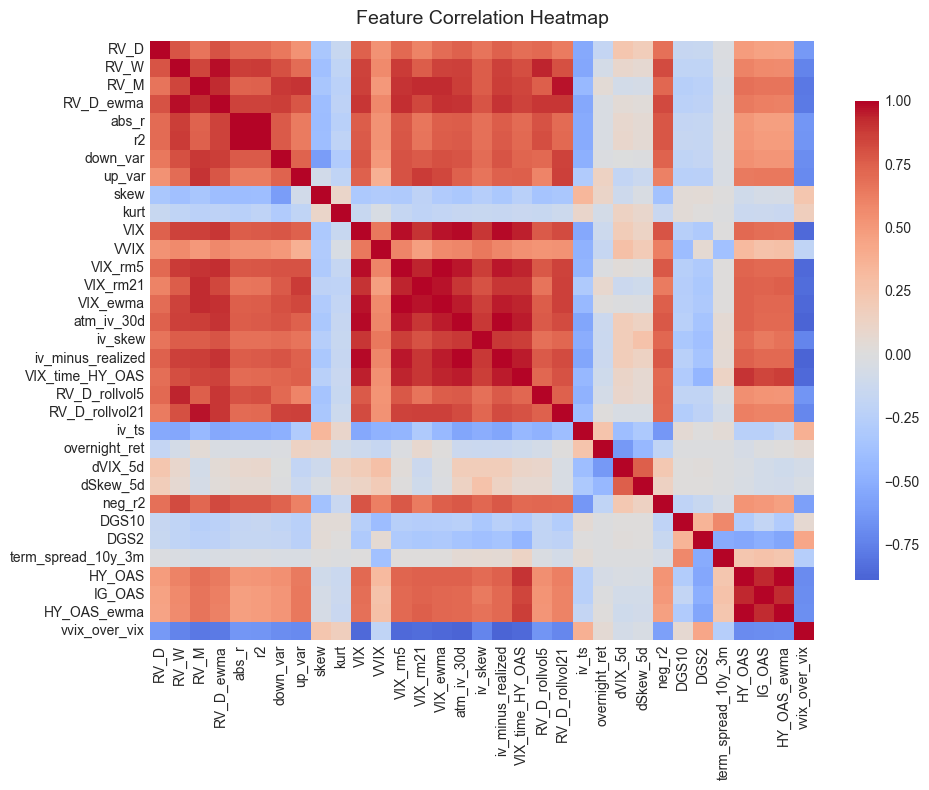

In [2211]:
corr = X_clean.corr()

plt.figure(figsize=(10, 8))  # adjust size

sns.heatmap(
    corr,
    cmap="coolwarm",        
    center=0,                   
    cbar_kws={"shrink": .8}
)

plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

In [2212]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_pairs = (
    upper.stack()
         .loc[lambda s: s > 0.95] 
         .sort_values(ascending=False)
)
print(high_pairs)

atm_iv_30d         iv_minus_realized    0.999999
VIX_rm5            VIX_ewma             0.994107
HY_OAS             HY_OAS_ewma          0.990606
abs_r              r2                   0.987160
VIX                atm_iv_30d           0.984047
                   iv_minus_realized    0.983999
                   VIX_rm5              0.972769
RV_W               RV_D_ewma            0.970479
VIX                VIX_ewma             0.966937
VIX_rm21           VIX_ewma             0.965546
RV_M               RV_D_rollvol21       0.964809
VIX_rm5            atm_iv_30d           0.960073
                   iv_minus_realized    0.959925
VIX_ewma           atm_iv_30d           0.955040
                   iv_minus_realized    0.954847
atm_iv_30d         VIX_time_HY_OAS      0.953364
iv_minus_realized  VIX_time_HY_OAS      0.953324
dtype: float64


In [2213]:
corr_features_to_drop = [
    "atm_iv_30d", "iv_minus_realized", "r2",
    "VIX_rm5", "RV_D_ewma", "HY_OAS", "VIX_ewma", "RV_D_rollvol21"
]
X_clean = X_clean.drop(corr_features_to_drop, axis=1)


---

# 7. **Modelling Framework**

## **7.1 Cross-Validation Scheme (Purged K-Fold)**

To evaluate feature importance **across regimes**, we need a CV scheme that respects the time-series structure of the data.  
Financial returns and volatility are **non-stationary**, so we don’t just want “one” importance estimate; we want to see how signals behave over the whole research period (2010–2020) without leaking information across time.

We therefore use a **Purged K-Fold** cross-validation:

- Folds are **contiguous in time** (no shuffling).
- For each test fold, we **purge** observations around it to remove overlap in:
  - the 21-day RV target horizon,
  - rolling windows used in the predictors.
- We also apply a small **embargo** after each test fold to avoid subtle look-ahead from nearby training points.

This gives us a sequence of non-overlapping validation blocks covering the full sample, letting us analyse **feature importance and stability across regimes** while controlling for the overlapping nature of the 21-day RV target.

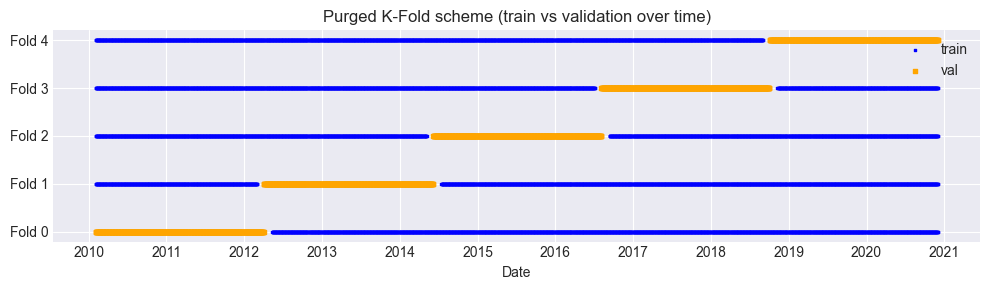

In [2215]:
from src.modelling.cross_validation import PurgedKFold

purged_cv = PurgedKFold(
    n_splits=5,      # ≈ 2-year validation blocks
    purge_gap=21,   # 21-day RV horizon
    embargo=0.01,  # 1% embargo after validaiton fold
)

ph.plot_purged_kfold_splits(purged_cv, X_clean, y_clean)

## 7.2 Model Specifications  

From the volatility forecasting literature and from our own exploratory analysis, we use **linear regression models** as the primary benchmark, and **Random Forests** as a flexible non-linear alternative.

The idea is:

- start from a standard **HAR-RV** econometric specification,  
- extend it to a **HAR-RV-X** model by adding a small set of predictors that show robust predictive power and have a clear economic interpretation (IV, term structure, VRP, overnight moves, etc.),  
- then compare these linear models to a non-linear **Random Forest** fitted on the same feature set.

### 7.2.1 Linear Models (HAR-RV and HAR-RV-X)  

We consider a baseline **HAR-RV** specification of the form:

$$
\text{RV}^{(21)}_{t+21}
= \beta_0 
+ \beta_D \,\text{RV}^{(1)}_t
+ \beta_W \,\text{RV}^{(5)}_t
+ \beta_M \,\text{RV}^{(21)}_t
+ \varepsilon_{t+21},
$$

where $\text{RV}^{(k)}_t$ denotes a $k$-day average of past daily realized variance (HAR daily/weekly/monthly structure).

We then extend this to a more general **HAR-RV-X** model:

$$
\text{RV}^{(21)}_{t+21}
= \beta_0 
+ \beta_D \,\text{RV}^{(1)}_t
+ \beta_W \,\text{RV}^{(5)}_t
+ \beta_M \,\text{RV}^{(21)}_t
+ \gamma^\top X_t
+ \varepsilon_{t+21},
$$

where $X_t$ collects additional predictors (IV level, IV–RV spread, term structure, skew, overnight returns, macro/sentiment variables, etc.) that are selected based on feature-importance and stability analysis in Section 8.

In [2216]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression() # HAR-RV / HAR-RV-X

### 7.2.2 Non-Linear Model (Random Forest)  

As a non-linear benchmark we use a **Random Forest regressor**:

$$
\widehat{\text{RV}}^{(21)}_{t+21}
= f_{\text{RF}}(X_t),
$$

where $f_{\text{RF}}$ is an ensemble of decision trees fitted on the same feature vector \(X_t\).  
Random Forests can capture non-linearities and interaction effects (e.g. regime-dependent impact of VIX, IV term structure, or macro variables) that are not modelled explicitly in the linear HAR-RV-X specification.

In [2217]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=5,
    n_jobs=-1,
)

# **8. Model Selection & Feature Importance**

The goal of this section is to identify **which features matter** for 21-day RV and **how stable** they are across time.

We combine several importance measures, both **in-sample** and **out-of-sample**, for **linear** and **non-linear** models to:

- confirm core predictors (RV lags, VIX / IV),
- gauge the usefulness of weaker signals (macro, sentiment, flow),
- and remove clearly irrelevant or redundant variables.

For **Random Forests**, with ~30 features, we mainly use feature importance to remove clearly useless or highly redundant predictors and to reduce training time — the model is relatively robust to modest amounts of noise.

For the **linear HAR-RV-X specifications**, we are much stricter: the aim is a small, interpretable model. A feature is a candidate for inclusion only if it satisfies all of:

1. **Economic sense** — clear story and expected sign.  
2. **Coefficient stability** across folds — non-zero and sign-stable.  
3. **Out-of-sample predictive power** — permutation importance clearly above noise.  
4. **Non-redundancy** — not just a near-duplicate of an existing core feature (e.g. another clone of RV\_M or VIX).

## Single-Feature Importance (SFI)

We use SFI only as a quick diagnostic for linear models, to see which features have **any standalone predictive power** for the 21-day RV.

A nice property is that it is immune to **substitution effects** from multicollinearity, since we regress the target on one feature at a time. However, it ignores **interactions and joint effects**: some predictors may be weak alone but useful in combination.  

Therefore, SFI is used as a **complementary tool**, not as a standalone feature selection method.

In [2218]:
from sklearn.metrics import r2_score, mean_squared_error

def run_sfi_linear(X, y, cv, lr, metric="r2"):
    """
    Single-Feature Importance (SFI) for linear models.

    For each feature x_j:
      - Fit y ~ x_j in each CV train fold
      - Compute OOS R² on that fold's validation
    Returns a DataFrame with mean and std OOS R² per feature.
    """
    X = pd.DataFrame(X)
    y = pd.Series(y)
    features = X.columns.to_list()
    n_features = X.shape[1]
    n_folds = cv.get_n_splits(X, y)

    scores = np.zeros((n_folds, n_features))

    for fold, (tr, val) in enumerate(cv.split(X, y)):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_val, y_val = X.iloc[val], y.iloc[val]

        for j, col in enumerate(features):
            x_tr = X_tr[[col]]  # keep as DataFrame
            x_val = X_val[[col]]

            lr.fit(x_tr, y_tr)
            y_pred = lr.predict(x_val)

            if metric == "r2":
                score = r2_score(y_val, y_pred)
            elif metric == "mse":
                score =  mean_squared_error(y_val, y_pred)
            scores[fold, j] = score

    # aggregate per feature
    sfi_df = pd.DataFrame({
        "feature": features,
        f"mean_{metric}": scores.mean(axis=0),
        f"std_{metric}": scores.std(axis=0),
    }).sort_values(f"mean_{metric}", ascending=False if metric == "r2" else True)

    return sfi_df, scores

In [2219]:
sfi_df, scores = run_sfi_linear(X_clean, y_clean, purged_cv, lin_model)
sfi_df.head(10)

,feature,mean_r2,std_r2
8,VIX,0.294929,0.086601
12,VIX_time_HY_OAS,0.209846,0.087117
10,VIX_rm21,0.097467,0.093864
11,iv_skew,0.086281,0.207520
1,RV_W,0.081386,0.160824
2,RV_M,0.074438,0.107090
24,vvix_over_vix,-0.020182,0.413011
18,neg_r2,-0.040659,0.309093
4,down_var,-0.100095,0.222663
13,RV_D_rollvol5,-0.102031,0.256368


### Extract the best $\alpha$ for Lasso fitting usign Purged KFold Cross validation

In [2220]:
from sklearn.linear_model import Lasso

lasso_cv = LassoCV(
        alphas=np.logspace(-4, 0, 30),
        cv=purged_cv,
        max_iter=100000,
        n_jobs=-1
)
lasso_cv.fit(X_clean, y_clean)
lasso = Lasso(alpha=lasso_cv.alpha_)

## 7.2 In-model stability analysis (with substitution effects)

Here we look at **in-sample explanatory power** in a multivariate setting, where substitution effects (multicollinearity) can appear.

- **Linear models (Lasso)**  
  We examine Lasso coefficients across validation folds and check:
  - how often a feature’s coefficient is non-zero,
  - whether its sign is stable.
  
  Features that are consistently shrunk to (or near) zero in-sample are treated as having **no meaningful explanatory power** and are candidates for removal. If a variable cannot explain the target even in-sample, any apparent predictive power is likely spurious.

- **Random Forest (RF)**  
  We use the standard **Mean Decrease in Impurity (MDI)** importance (as in López de Prado) computed per fold.  
  Features with consistently negligible MDI are treated as **completely useless** and can be dropped from the RF feature set.

In [2221]:
def in_sample_stability(X, y, lasso, rf, cv):
    """
    In-model stability: coefficients for Lasso, MDI feature importance for RF
    across folds.

    Returns
    -------
    df_lasso : DataFrame
        Columns: ['feature', 'mean_coef', 'std_coef', 'mean_abs_coef'],
        sorted by |mean_coef| descending.
    df_rf : DataFrame
        Columns: ['feature', 'mean_fi', 'std_fi'],
        sorted by mean_fi descending.
    coefs : ndarray, shape (n_folds, n_features)
    rf_fi : ndarray, shape (n_folds, n_features)
    """
    X = pd.DataFrame(X)
    y = pd.Series(y)
    features = X.columns.to_list()

    n_features = X.shape[1]
    n_folds = cv.get_n_splits(X, y)

    coefs = np.zeros((n_folds, n_features))
    rf_fi = np.zeros((n_folds, n_features))

    for fold, (tr, val) in enumerate(cv.split(X, y)):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]

        lasso.fit(X_tr, y_tr)
        rf.fit(X_tr, y_tr)

        coefs[fold, :] = lasso.coef_
        rf_fi[fold, :] = rf.feature_importances_

    # Aggregate for Lasso
    mean_coef = coefs.mean(axis=0)
    std_coef = coefs.std(axis=0)
    mean_abs_coef = np.abs(coefs).mean(axis=0)

    df_lasso = pd.DataFrame({
        "feature": features,
        "mean_coef": mean_coef,
        "std_coef": std_coef,
        "mean_abs_coef": mean_abs_coef,
    }).sort_values("mean_abs_coef", ascending=False)

    # Aggregate for RF
    mean_fi = rf_fi.mean(axis=0)
    std_fi = rf_fi.std(axis=0)

    df_rf = pd.DataFrame({
        "feature": features,
        "mean_fi": mean_fi,
        "std_fi": std_fi,
    }).sort_values("mean_fi", ascending=False)

    return df_lasso, df_rf, coefs, rf_fi

In [2222]:
df_lasso, df_rf, lasso_coefs, rf_fi = in_sample_stability(X_clean, y_clean, lasso, rf, purged_cv)

## Lasso

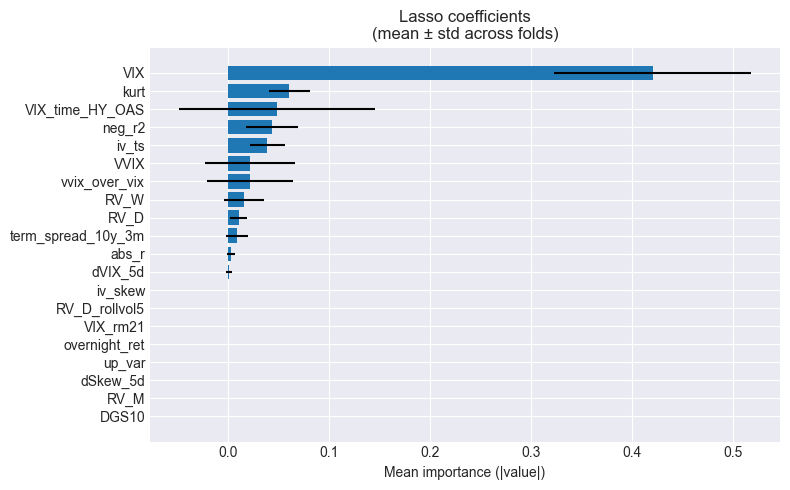

In [2224]:
feature_names = X_clean.columns

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# 1) Lasso coefficients
ph.plot_mean_std_importance(
    axes,
    lasso_coefs,
    feature_names,
    title="Lasso coefficients\n(mean ± std across folds)",
    top_n=20,
    abs_values=True,
)

plt.tight_layout()
plt.show()

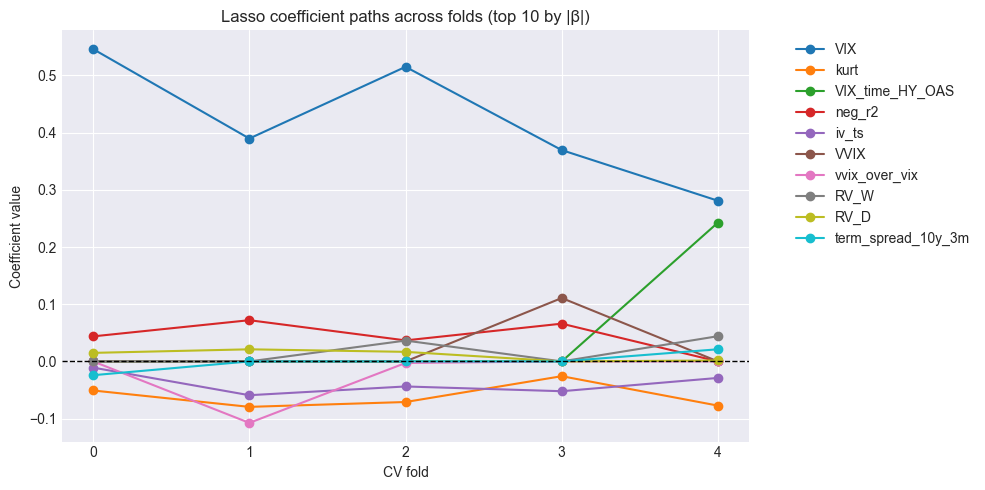

<Axes: >

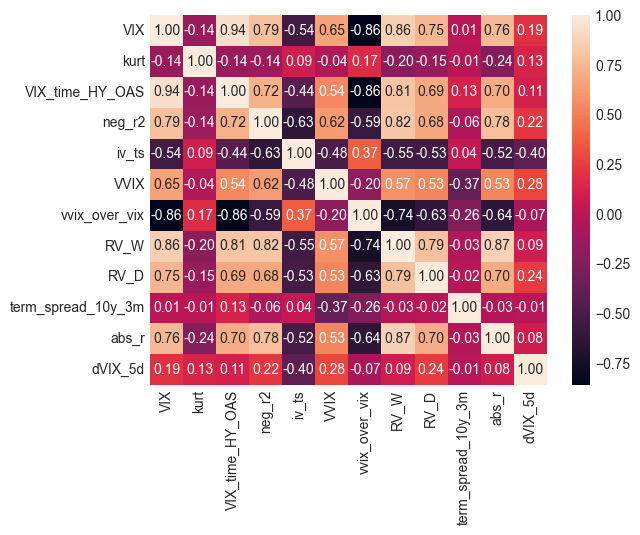

In [2225]:
feature_names = X_clean.columns
ph.plot_lasso_coef_paths(lasso_coefs, feature_names, top_n=10)

lasso_features = df_lasso.loc[df_lasso["mean_coef"].abs() > 0.0, "feature"]
sns.heatmap(X_clean[lasso_features].corr(), annot=True, fmt=".2f")

- the feature VIX_time_HY_OAS is a regime-specific candidate that only strats to become meangiful durign covid period in high IR environement. Thus not beign a core stable predictor as well as being strongly corremated with the  VIX \rho = 0.94, thus we prefer keeping VIX whihc is relevent across all time periods and exlcude it from now has it is likely to falsify the permutation importance.

In [2227]:
X_clean_lin = X_clean[lasso_features].drop(["VIX_time_HY_OAS"], axis=1)
X_clean_lin = X_clean[lasso_features]

## Random Forest

Here the purpose of this cehck is to remove the compeletely junk features whihc are never sleetced across the 500 uncconstrained trees in order to reduce the impurity.

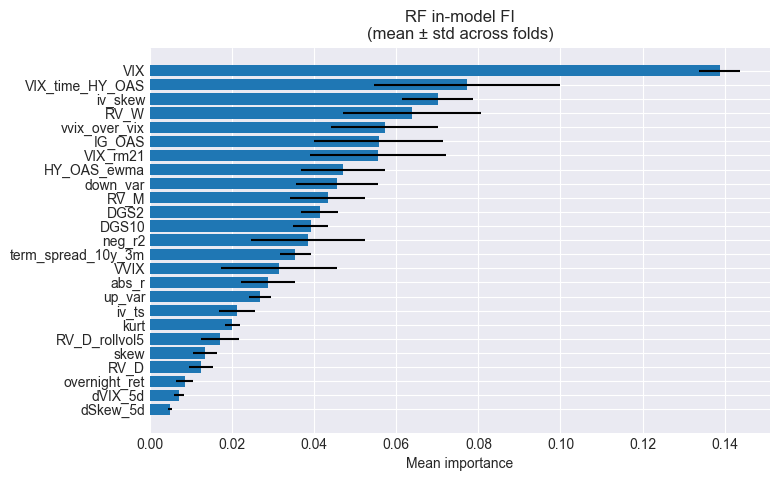

In [2228]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# 2) RF in-model FI (MDI)
ph.plot_mean_std_importance(
    axes,
    rf_fi,
    feature_names,
    title="RF in-model FI\n(mean ± std across folds)",
    top_n=30,
    abs_values=False,
)


All the features are selected in sample in order to reduce the impurity. Thus they are all "relevent" in explanaotry importance and thus we decie to keep all of them even the leats imporrant one like dVIX and dSKew which could be imporant stress-regime predictors combined with otehr features

## OOS permutation importance (Mean Decrease Accuracy)

Here the prupose is to check wether features from the previous reduced feature ste for LR and teh entire ste for RF have some rpedicitv epower. 

However, because of substituion effects we inteprerit carefully the results below and consider and consider the previosuly obatien results from in smapel stability as well as economic rational.

In [2229]:
def oos_feature_importance(X, y, lr, rf, cv, n_repeats=30, scoring="neg_mean_squared_error", random_state=0):
    """
    OOS permutation importance MDA (Mean Decrease Accuracy) computed on the validation folds.
    """
    n_features = X.shape[1]
    n_folds = cv.get_n_splits(X, y)
    
    pi_lasso = np.zeros((n_folds, n_features))
    pi_rf = np.zeros((n_folds, n_features))

    for fold, (tr, val) in enumerate(cv.split(X, y)):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_val, y_val = X.iloc[val], y.iloc[val]

        lr.fit(X_tr, y_tr)
        rf.fit(X_tr, y_tr)

        # Lasso PI on validation
        r_lasso = permutation_importance(
            lr, X_val, y_val,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1,
        )
        pi_lasso[fold, :] = r_lasso.importances_mean

        # RF PI on validation
        r_rf = permutation_importance(
            rf, X_val, y_val,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1,
        )
        pi_rf[fold, :] = r_rf.importances_mean

    return pi_lasso, pi_rf

## Linear Regression

In [2230]:
lasso_pi, _ = oos_feature_importance(X_clean_lin, y_clean, lin_model, rf, purged_cv, scoring="neg_mean_squared_error")

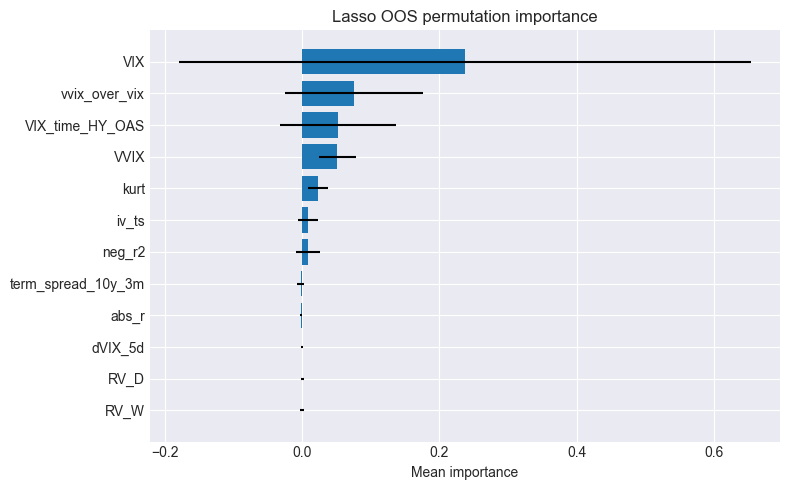

In [2231]:
feature_names = X_clean_lin.columns

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# 3) Lasso OOS permutation importance
ph.plot_mean_std_importance(
    axes,
    lasso_pi,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=20,
    abs_values=False,
)
plt.tight_layout()
plt.show()

- `log_kurtosis` is statistically active across folds and not highly correlated with other features, but its coefficient is **consistently negative**, which contradicts the intuition that high past kurtosis should signal higher future RV. Despite some predictive power, we treat it as a likely **statistical artefact** and exclude it from HAR-RV-X.

- `winsor_iv_ts` has **stable coefficients**, a **consistent negative sign** (economically reasonable for an inverted IV term structure), **moderate OOS importance**, and low correlation with other predictors, so we keep it as a candidate for HAR-RV-X.

- `sqrt_neg_r2` is also stable across folds, shows clear predictive power, and has a strong economic rationale (captures the **leverage effect**), so we include it in HAR-RV-X.

- Other features fail at least one of our criteria (unstable sign or near-zero coefficients, no clear OOS importance, or weak economic story) and are not retained in the parsimonious linear specification.

## Random Forest

In [2232]:
_, rf_pi = oos_feature_importance(X_clean, y_clean, lin_model, rf, purged_cv, scoring="neg_mean_squared_error")

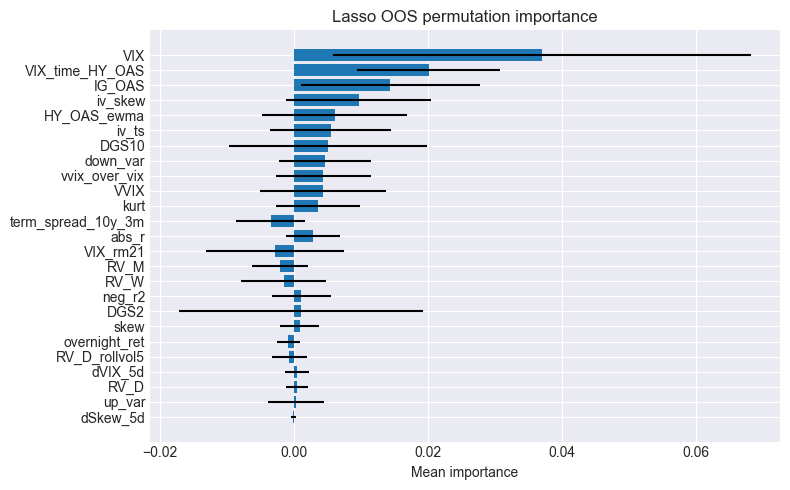

In [2233]:
feature_names = X_clean.columns

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# 3) Lasso OOS permutation importance
ph.plot_mean_std_importance(
    axes,
    rf_pi,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=30,
    abs_values=False,
)
plt.tight_layout()
plt.show()

In [2234]:
features_to_drop = ["term_spread_10y_3m", # slight importance in sample but no OOS and no strong eco
                    "VIX_rm21", # still relevent in sample  but corr 92% with RV_M and no rel OOS
                    "DGS2", # OOS importance is varies too much and not siginificnat, no strong eco rel
                    "up_var",
                    "RV_D_rollvol5", # no rel IS and OOS, too corrleated with RV_W
                    "dSkew_5d", # no used IS and OOS (junk feature)
                    "overnight_ret" # no importance iS and neg contrib with low std OOS
]
X_clean_rf = X_clean.drop(features_to_drop, axis=1)
features_rf = X_clean_rf.columns.tolist()

# **9. Model Selection**

We consider three nested HAR-type specifications:

1. **HAR-RV**  
   The classical benchmark that uses only realized volatility lags to forecast future RV.  
   This model is well established in the volatility-forecasting literature.

2. **HAR-RV-VIX**  
   A natural extension that augments HAR-RV with a froward looking volatility measure, the VIX.
   While this specification is less “canonical” than pure HAR-RV, it is documented
   in several studies that VIX can be seen as strong predictor for monhtly RV estimate.

3. **HAR-RV-VIX-X**  
   A further extension where we add a small set of economically motivated predictors
   \(X_t\) that show robust predictive power for forward RV.  
   In our case we consider:
   - **HAR-RV-VIX-L**: adding a leverage-effect proxy (here downside returns),
   - **HAR-RV-VIX-IVTS**: adding the IV term-structure slope,
   - **HAR-RV-VIX-L-IVTS**: combining both leverage and IV term-structure features.

These HAR-RV-VIX-X variants remain parsimonious and interpretable, and serve as
our main linear benchmarks against richer machine-learning models.


For Random Forest we use the reduced feature set and we tune the core hyperparameetrs (not too many to avoid overfitting).

In [2364]:
data = pd.concat([X, y], axis=1)
data = data.dropna()

X_train = data[X.columns] # apply on the raw untrasnformed feature set
y_train = data[y.name]

purged_cv = PurgedKFold(
    n_splits=10, # approx reffit every year
    purge_gap=21,
    embargo=0.01
)

dp = DataProcessor(
    log_features=log_features,
    winsor_sqrt_features=winsor_sqrt_features,
    winsor_features=winsor_features,
    scale=True
)

## Random Forest

In [ ]:
param_grid = {
    "rf__max_depth": [3, 5, 7],
    "rf__min_samples_leaf": [3, 510],
    "rf__n_estimators": [100, 200, 300],

}

rf = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)

pipe_rf = Pipeline([
    ("dp", dp), ("rf", rf)
])

gscv = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=purged_cv,
    n_jobs=-1,
)

X_train_rf = X_train[features_rf]

gscv.fit(X_train_rf, y_train)
print("Best params:", gscv.best_params_)

Best params: {'rf__max_depth': 3, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 300}


In [ ]:
from sklearn.model_selection import cross_val_predict

y_preds_rf = cross_val_predict(
    gscv.best_estimator_, X_train_rf, c,
    cv=purged_cv, n_jobs=-1,
)
y_preds_rf = pd.Series(y_preds_rf, index=X_train_rf.index)
r2_score(y_train, y_preds_rf)

0.4497200648846188

## Linear Models

In [2358]:
features_har_rv = ["RV_D", "RV_W", "RV_M"]
features_har_vix = features_har_rv + ["VIX"]
features_har_vix_l = features_har_vix + ["neg_r2"]
features_har_vix_ivts = features_har_vix + ["iv_ts"]
features_har_vix_l_ivts = features_har_vix + ["neg_r2", "iv_ts"]

pipe_lr = Pipeline([
    ("dp", DataProcessor(
        log_features=log_features,
        winsor_sqrt_features=winsor_sqrt_features,
        winsor_features=winsor_features,
        scale=True
    )),
    ("lr", LinearRegression()),
])

y_preds_lr = cross_val_predict(
    pipe_lr, X_clean[features_har_vix], y_clean,
    cv=purged_cv,
    n_jobs=-1,
)
y_preds_lr = pd.Series(y_preds_lr, index=y_clean.index)
r2_score(y_clean, y_preds_lr)

0.5091002157685307

In [2317]:
purged_cv = PurgedKFold(
    n_splits=10, # approx reffit every 3 months
    purge_gap=21,
    embargo=0.01
)

preds = cross_val_predict(
    lin_model, X_clean[["VIX", "RV_W", "RV_M", "RV_D", "iv_ts", "neg_r2"]], y_clean,
    cv=purged_cv,
    n_jobs=-1,
)
preds = pd.Series(preds, index=y_clean.index)
r2_score(y_clean, preds)

0.46167234670485935

In [2360]:
r2_score(y_clean, 0.8*y_preds_lr + 0.2*y_preds_rf)

0.5047983976739092